# Non merging inputs

TODO:
 - [X] Is it better with full or the balanced dataset? -> Non balanced (even better when excluding non-coherent data)
 - [X] Try conformal with the decade -> Too few classes, argmax is way better

In [29]:
import os
# cuda_visible_devices = 0,1,2,3
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

import pandas as pd

import numpy as np
from tabulate import tabulate
import seaborn as sns
from tqdm import tqdm

# import nltk
# from nltk import WordPunctTokenizer
# from nltk import TreebankWordTokenizer

# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('stopwords')
# nltk.download('wordnet')

# from nltk.corpus import stopwords

# import stanza
# stanza.download('en')


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
from collections import Counter
from tabulate import tabulate
from transformers import AutoModel, AutoTokenizer

RANDOM_SEED = 42

## Data Loading

In [2]:
texts_path = './data/Task2/texts'

train_path = os.path.join(texts_path, 'train')
valid_path = os.path.join(texts_path, 'valid')

train_files = os.listdir(train_path)
valid_files = os.listdir(valid_path)

print(f"Task2.1 => Train: {len(train_files)}, Test: {len(valid_files)}")

label2century = {1: '17th century', 2: '18th century', 3: '19th century', 4: '20th century', 5: '21st century'}

train21 = pd.read_csv('./data/Task2/task2.1/train.csv')
valid21 = pd.read_csv('./data/Task2/task2.1/valid.csv')

train22 = pd.read_csv('./data/Task2/task2.2/train.csv')
valid22 = pd.read_csv('./data/Task2/task2.2/valid.csv')

train21.rename(columns={'label': 'century'}, inplace=True)
train21['file_name'] = train21['id']
train21['id'] = train21.id.str.replace('train_text', '').str.replace('.txt', '').astype(int)
train21.set_index('id', inplace=True)

valid21.rename(columns={'label': 'century'}, inplace=True)
valid21['file_name'] = valid21['id']
valid21['id'] = valid21.id.str.replace('valid_text', '').str.replace('.txt', '').astype(int)
valid21.set_index('id', inplace=True)

Task2.1 => Train: 204708, Test: 54652


In [3]:
train22 = pd.read_csv('./data/Task2/task2.2/train.csv')
valid22 = pd.read_csv('./data/Task2/task2.2/valid.csv')

train22.rename(columns={'label': 'decade'}, inplace=True)
train22['file_name'] = train22['id']
train22['id'] = train22.id.str.replace('train_text', '').str.replace('.txt', '').astype(int)
train22.set_index('id', inplace=True)

valid22.rename(columns={'label': 'decade'}, inplace=True)
valid22['file_name'] = valid22['id']
valid22['id'] = valid22.id.str.replace('valid_text', '').str.replace('.txt', '').astype(int)
valid22.set_index('id', inplace=True)

print(f"Task2.2 => Train: {len(train22)}, Test: {len(valid22)}")

Task2.2 => Train: 204708, Test: 54651


In [4]:
# Load the list of IDs that are not coherent with the Task1 dataset

import pickle
with open('blacklist.pkl', 'rb') as f:
    blacklist = pickle.load(f)

blacklist_train = blacklist['train']
blacklist_valid = blacklist['valid']

In [5]:
def decade2year(deca):
    return ((deca // 10) + 16) * 100 + ((deca % 10)) * 10

def year2cd(year):
    return ((year // 100 - 16) * 10  + (year - (year // 100)*100)//10)

In [6]:
import ftfy

def get_clean_text(path):
    
    with open(path, 'rb') as infile:
        txt_ry = infile.read()
    misdecoded_text = txt_ry.decode("utf-8", errors="ignore")

    return ftfy.fix_text(misdecoded_text)

In [7]:
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, file_names, labels, path, clear=False):
        self.file_names = file_names
        self.labels = labels
        self.path = path
        self.clear = clear

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        if self.clear:
            text = get_clean_text(os.path.join(self.path, file_name))
        else:
            with open(os.path.join(self.path, file_name), 'r') as file:
                text = file.read()

        return text, self.labels[idx]

In [10]:
# Load all the data

X_train_21 = []
y_train_21 = []

X_valid_21 = []
y_valid_21 = []

for idx, row in train21.iterrows():
    file_name = row.file_name
    century = row.century
    X_train_21.append(file_name)
    y_train_21.append(century-1)

for idx, row in valid21.iterrows():
    file_name = row.file_name
    century = row.century
    X_valid_21.append(file_name)
    y_valid_21.append(century-1)

In [11]:
# Load data making sure that each class has the same amount of data (undersampling)

np.random.seed(RANDOM_SEED)

X_train_21_eq = []
y_train_21_eq = []
for i in range(1, 6):
    x = train21[train21['century'] == i].sample(1834)
    X_train_21_eq.extend(x['file_name'])
    y_train_21_eq.extend(x['century']-1)

X_valid_21_eq = []
y_valid_21_eq = []
for i in range(1, 6):
    x = valid21[valid21['century'] == i].sample(457)
    X_valid_21_eq.extend(x['file_name'])
    y_valid_21_eq.extend(x['century']-1)

In [12]:
X_train_22 = []
y_train_22 = []

X_valid_22 = []
y_valid_22 = []

for idx, row in train22.iterrows():
    file_name = row.file_name
    decade = row.decade
    X_train_22.append(file_name)
    y_train_22.append(decade-1)

for idx, row in valid22.iterrows():
    file_name = row.file_name
    decade = row.decade
    X_valid_22.append(file_name)
    y_valid_22.append(decade-1)

In [13]:
X_train_22_eq = []
y_train_22_eq = []
for x in tqdm(X_train_21_eq):
    row = train22[train22['file_name'] == x]
    decade = int(row.decade)
    X_train_22_eq.append(x)
    y_train_22_eq.append(decade)
    
X_valid_22_eq = []
y_valid_22_eq = []
for x in X_valid_21_eq:
    row = valid22[valid22['file_name'] == x]
    decade = int(row.decade)
    X_valid_22_eq.append(x)
    y_valid_22_eq.append(decade)

  0%|                                                                                                                                                                                        | 0/9170 [00:00<?, ?it/s]/tmp/ipykernel_641339/2300074627.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  decade = int(row.decade)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9170/9170 [01:40<00:00, 91.11it/s]
/tmp/ipykernel_641339/2300074627.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  decade = int(row.decade)


In [14]:
# Task 2.1 ========================
# Full
train21_dataset = TextDataset(X_train_21, y_train_21, train_path)
valid21_dataset = TextDataset(X_valid_21, y_valid_21, valid_path)

batch_size = 16
train21_dataloader = DataLoader(train21_dataset, batch_size=batch_size, shuffle=True)
valid21_dataloader = DataLoader(valid21_dataset, batch_size=batch_size, shuffle=False)

# Undersampling
train21_eq_dataset = TextDataset(X_train_21_eq, y_train_21_eq, train_path)
valid21_eq_dataset = TextDataset(X_valid_21_eq, y_valid_21_eq, valid_path)

batch_size = 16
train21_eq_dataloader = DataLoader(train21_eq_dataset, batch_size=batch_size, shuffle=True)
valid21_eq_dataloader = DataLoader(valid21_eq_dataset, batch_size=batch_size, shuffle=False)

# Task 2.2 ========================
# Full
train22_dataset = TextDataset(X_train_22, y_train_22, train_path)
valid22_dataset = TextDataset(X_valid_22, y_valid_22, valid_path)

batch_size = 16
train22_dataloader = DataLoader(train22_dataset, batch_size=batch_size, shuffle=True)
valid22_dataloader = DataLoader(valid22_dataset, batch_size=batch_size, shuffle=False)

# Undersampling
train22_eq_dataset = TextDataset(X_train_22_eq, y_train_22_eq, train_path)
valid22_eq_dataset = TextDataset(X_valid_22_eq, y_valid_22_eq, valid_path)

batch_size = 16
train22_eq_dataloader = DataLoader(train22_eq_dataset, batch_size=batch_size, shuffle=True)
valid22_eq_dataloader = DataLoader(valid22_eq_dataset, batch_size=batch_size, shuffle=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204708/204708 [08:47<00:00, 388.37it/s]


Token Length Statistics:
- Maximum: 9481
- Mean: 1395.41
- Median: 1325.00
- 95th percentile: 1876.00
- 99th percentile: 2235.00


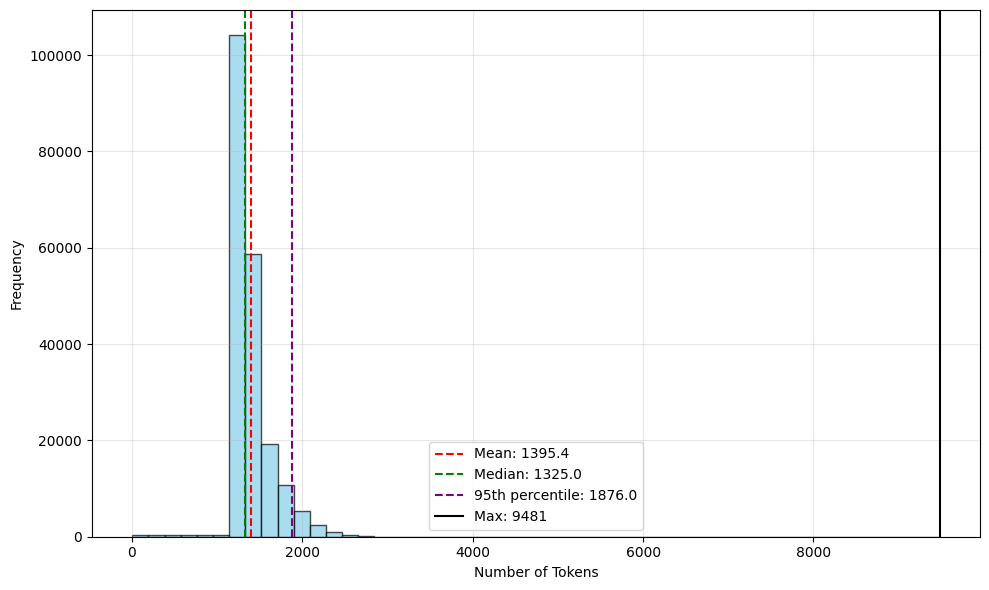

In [30]:
tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")

token_lengths = []
for text, _ in tqdm(train21_dataset):
    tokens = tokenizer(text, add_special_tokens=True, return_tensors="pt")
    token_lengths.append(tokens['input_ids'].shape[1])

# Calculate statistics
max_length = max(token_lengths)
mean_length = np.mean(token_lengths)
median_length = np.median(token_lengths)
p95_length = np.percentile(token_lengths, 95)
p99_length = np.percentile(token_lengths, 99)

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.1f}')
plt.axvline(x=median_length, color='green', linestyle='--', label=f'Median: {median_length:.1f}')
plt.axvline(x=p95_length, color='purple', linestyle='--', label=f'95th percentile: {p95_length:.1f}')
plt.axvline(x=max_length, color='black', linestyle='-', label=f'Max: {max_length}')

plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

print(f"Token Length Statistics:")
print(f"- Maximum: {max_length}")
print(f"- Mean: {mean_length:.2f}")
print(f"- Median: {median_length:.2f}")
print(f"- 95th percentile: {p95_length:.2f}")
print(f"- 99th percentile: {p99_length:.2f}")

In [21]:
cg = 0
cg_list = []
cg_labels = []
for idx, file_name in tqdm(enumerate(X_train_21), total=len(X_train_21)):
    
    tidx = int(file_name.replace('train_text', '').replace('.txt', ''))
    if tidx in blacklist_valid:
        continue
    with open(os.path.join(train_path, file_name), 'r') as file:
        text = file.read()
    
    if 'gutenberg' in text.lower(): # and 'project' not in text.lower() :
        cg += 1
        cg_list.append(text)
        cg_labels.append(y_train_21[idx])
print(cg)

print(Counter(cg_labels))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204708/204708 [00:11<00:00, 18472.76it/s]

2128
Counter({2: 1736, 3: 181, 1: 117, 0: 75, 4: 19})


In [25]:
for cgl in cg_list[:2]:
    print(cgl[:150])

you do or cause to occur: (a) distribution of this or any Project Gutenberg-tm work, (b) alteration, modification, or additions or deletions to any Pr
do not necessarily keep eBooks in compliance with any particular paper edition. Most people start at our Web site which has the main PG search facilit


In [26]:
def mean_avg_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

## Century classifier

In [183]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CenturyClassifier(nn.Module):
    def __init__(self, longformer, num_classes):
        super(CenturyClassifier, self).__init__()
        self.bert = longformer
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(longformer.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

In [31]:
def train_century_classifier(model, tokenizer, train_dataloader, n_epochs=3):
    
    model_century_classifier = CenturyClassifier(model, 5)
    model_century_classifier.to(device)
    
    optimizer = optim.Adam(model_century_classifier.parameters(), lr=1e-5)
    criterion = nn.CrossEntropyLoss()
    
    model_century_classifier.train()
    
    for epoch in range(n_epochs):
        for text, labels in tqdm(train_dataloader):
            optimizer.zero_grad()
            tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512,).to(device)
            labels = torch.tensor(labels).to(device)
            output = model_century_classifier(**tokens)
            loss = criterion(output.view(-1, 5), labels.view(-1))
            loss.backward()
            optimizer.step()
        print("Epoch:", epoch, "Loss:", loss.item())
    
    return model_century_classifier

In [135]:
tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
model = AutoModel.from_pretrained("allenai/longformer-base-4096")

# # Balanced dataset
# model_century_classifier_eq = train_century_classifier(model, tokenizer, train21_eq_dataloader)
# 
# tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
# model = AutoModel.from_pretrained("allenai/longformer-base-4096")
# 
# # Full dataset
# model_century_classifier = train_century_classifier(model, tokenizer, train21_dataloader)

  0%|                                                                                                                                                                                         | 0/574 [00:00<?, ?it/s]/tmp/ipykernel_518077/2369404271.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 574/574 [05:59<00:00,  1.60it/s]


Epoch: 0 Loss: 1.28499174118042


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 574/574 [05:59<00:00,  1.60it/s]


Epoch: 1 Loss: 1.2889608144760132


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 574/574 [05:59<00:00,  1.60it/s]

Epoch: 2 Loss: 0.39171406626701355


### Evaluation

In [32]:
def plot_confusion_matrix(y_true, y_pred, n_classes=5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    tick_positions = np.arange(n_classes)

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm, cmap='Blues', ax=ax1)

    ax1.set_xticks(tick_positions + 0.5)
    ax1.set_xticklabels(tick_positions)
    ax1.set_title('Normalized Confusion Matrix')


    freq3 = np.zeros((n_classes,n_classes))
    for b, c in zip(y_true, y_pred):
        freq3[b,c] += 1

    sns.heatmap(freq3, cmap='rocket', ax=ax2, vmin=10, vmax=1000)

    ax2.set_xticks(tick_positions + 0.5)
    ax2.set_xticklabels(tick_positions)
    ax2.set_title('Frequency Heatmap')

    for dec_line in range(10,50,10):
        ax1.axvline(dec_line, color='red')
        ax1.axhline(dec_line, color='red')
        ax2.axvline(dec_line, color='red')
        ax2.axhline(dec_line, color='red')

    plt.tight_layout()
    plt.show()

In [14]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
model = AutoModel.from_pretrained("allenai/longformer-base-4096")

class CenturyClassifier(nn.Module):
    def __init__(self, longformer, num_classes):
        super(CenturyClassifier, self).__init__()
        self.bert = longformer
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(longformer.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

In [79]:
tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
model = AutoModel.from_pretrained("allenai/longformer-base-4096")

model_century_classifier = CenturyClassifier(model, 5)
model_century_classifier.load_state_dict(torch.load('models/task21/century_classifier_weights_3.pt'))
model_century_classifier.to(device)
model_century_classifier.eval()

model_century_classifier_equal = CenturyClassifier(model, 5)
model_century_classifier_equal.load_state_dict(torch.load('models/task21/century_classifier_weights_3_equal.pt'))
model_century_classifier_equal.to(device)
model_century_classifier_equal.eval()

model_century_classifier_blacklist = CenturyClassifier(model, 5)
model_century_classifier_blacklist.load_state_dict(torch.load('models/task21/century_classifier_weights_3_blacklist.pt'))
model_century_classifier_blacklist.to(device)
model_century_classifier_blacklist.eval()

model_century_classifier_equal_blacklist = CenturyClassifier(model, 5)
model_century_classifier_equal_blacklist.load_state_dict(torch.load('models/task21/century_classifier_weights_3_equal_blacklist.pt'))
model_century_classifier_equal_blacklist.to(device)
model_century_classifier_equal_blacklist.eval()
print("Loaded")

Loaded


In [80]:
model_century_classifier_full = CenturyClassifier(model, 5)
model_century_classifier_full.load_state_dict(torch.load('models/task21/century_classifier_best_val.pt'))
model_century_classifier_full.to(device)
model_century_classifier_full.eval()
print("Loaded")

Loaded


In [82]:
tv_probs = []
tv_preds = []
tv_true = []

model_century_classifier_full.eval()

with torch.no_grad():
    for text, labels in tqdm(valid21_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_century_classifier_full(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        tv_probs.extend(probabilities.detach().cpu().numpy())
        tv_preds.extend(predictions.detach().cpu().numpy())
        tv_true.extend(labels.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3416/3416 [31:49<00:00,  1.79it/s]


In [86]:
mean_avg_error(np.array(tv_true), np.array(tv_preds))
compute_class_mae(tv_true, tv_preds)

[1.222294442638934,
 0.45898203592814374,
 0.12904240028745959,
 0.07386888273314866,
 0.16849015317286653]

#### Standard

In [20]:
## Run 

## CUDA_VISIBLE_DEVICES={ID} python3 eval_task21.py [--equal] [--blacklist]

In [51]:
# Load results

with open('results/task21/full/century_classifier_weights_3.pkl', 'rb') as f:
    mcc = pickle.load(f)
    
with open('results/task21/full/century_classifier_weights_3_equal.pkl', 'rb') as f:
    mcce = pickle.load(f)
    
with open('results/task21/full/century_classifier_weights_3_blacklist.pkl', 'rb') as f:
    mccb = pickle.load(f)
    
with open('results/task21/full/century_classifier_weights_3_equal_blacklist.pkl', 'rb') as f:
    mcceb = pickle.load(f)
    
    
with open('results/task21/blacklist/century_classifier_weights_3.pkl', 'rb') as f:
    bmcc = pickle.load(f)
    
with open('results/task21/blacklist/century_classifier_weights_3_equal.pkl', 'rb') as f:
    bmcce = pickle.load(f)
    
with open('results/task21/blacklist/century_classifier_weights_3_blacklist.pkl', 'rb') as f:
    bmccb = pickle.load(f)
    
with open('results/task21/blacklist/century_classifier_weights_3_equal_blacklist.pkl', 'rb') as f:
    bmcceb = pickle.load(f)

In [85]:
def compute_class_mae(y_true, y_pred, n_classes=5):
    class_maes = []
    for i in range(n_classes):
        indices = [idx for idx, label in enumerate(y_true) if label == i]
        if indices:
            class_mae = mean_avg_error(np.array([y_true[idx] for idx in indices]), 
                                        np.array([y_pred[idx] for idx in indices]))
            class_maes.append(class_mae)
        else:
            class_maes.append(float('nan'))
    return class_maes

def count_class_frequencies(y_true, n_classes=5):
    frequencies = [0] * n_classes
    for label in y_true:
        frequencies[label] += 1
    return frequencies

In [197]:
table_data = []

# Base model
overall_mae_base = mean_avg_error(np.array(mcc['true_labels']), np.array(mcc['predictions']))
class_maes_base = compute_class_mae(mcc['true_labels'], mcc['predictions'])
class_freqs_base = count_class_frequencies(mcc['true_labels'])
base_row = ["Base", f"{overall_mae_base:.4f} [{len(mcc['true_labels'])}]"]
for i, mae in enumerate(class_maes_base):
    base_row.append(f"{mae:.4f} [{class_freqs_base[i]}]")
table_data.append(base_row)

# Equal model
overall_mae_equal = mean_avg_error(np.array(mcce['true_labels']), np.array(mcce['predictions']))
class_maes_equal = compute_class_mae(mcce['true_labels'], mcce['predictions'])
class_freqs_equal = count_class_frequencies(mcce['true_labels'])
equal_row = ["Equal", f"{overall_mae_equal:.4f} [{len(mcce['true_labels'])}]"]
for i, mae in enumerate(class_maes_equal):
    equal_row.append(f"{mae:.4f} [{class_freqs_equal[i]}]")
table_data.append(equal_row)

# Blacklist model
overall_mae_blacklist = mean_avg_error(np.array(mccb['true_labels']), np.array(mccb['predictions']))
class_maes_blacklist = compute_class_mae(mccb['true_labels'], mccb['predictions'])
class_freqs_blacklist = count_class_frequencies(mccb['true_labels'])
blacklist_row = ["Blacklist", f"{overall_mae_blacklist:.4f} [{len(mccb['true_labels'])}]"]
for i, mae in enumerate(class_maes_blacklist):
    blacklist_row.append(f"{mae:.4f} [{class_freqs_blacklist[i]}]")
table_data.append(blacklist_row)

# Equal-Blacklist model
overall_mae_equal_blacklist = mean_avg_error(np.array(mcceb['true_labels']), np.array(mcceb['predictions']))
class_maes_equal_blacklist = compute_class_mae(mcceb['true_labels'], mcceb['predictions'])
class_freqs_equal_blacklist = count_class_frequencies(mcceb['true_labels'])
equal_blacklist_row = ["Equal-Blacklist", f"{overall_mae_equal_blacklist:.4f} [{len(mcceb['true_labels'])}]"]
for i, mae in enumerate(class_maes_equal_blacklist):
    equal_blacklist_row.append(f"{mae:.4f} [{class_freqs_equal_blacklist[i]}]")
table_data.append(equal_blacklist_row)

print(tabulate(table_data,
               ["Model", "Overall MAE", "Century 0", "Century 1", "Century 2", "Century 3", "Century 4"], 
               tablefmt="grid"))

+-----------------+----------------+---------------+---------------+----------------+---------------+--------------+
| Model           | Overall MAE    | Century 0     | Century 1     | Century 2      | Century 3     | Century 4    |
+=================+================+===============+===============+================+===============+==============+
| Base            | 0.1993 [54651] | 1.5580 [3077] | 0.7470 [3340] | 0.0712 [44528] | 0.0890 [3249] | 0.3129 [457] |
+-----------------+----------------+---------------+---------------+----------------+---------------+--------------+
| Equal           | 1.0868 [54651] | 1.1901 [3077] | 1.0114 [3340] | 1.1466 [44528] | 0.3598 [3249] | 0.2823 [457] |
+-----------------+----------------+---------------+---------------+----------------+---------------+--------------+
| Blacklist       | 0.1849 [54651] | 2.0101 [3077] | 0.9174 [3340] | 0.0086 [44528] | 0.0883 [3249] | 0.4026 [457] |
+-----------------+----------------+---------------+------------

In [198]:
table_data = []


# Base model
overall_mae_base = mean_avg_error(np.array(bmcc['true_labels']), np.array(bmcc['predictions']))
class_maes_base = compute_class_mae(bmcc['true_labels'], bmcc['predictions'])
class_freqs_base = count_class_frequencies(bmcc['true_labels'])
base_row = ["Base", f"{overall_mae_base:.4f} [{len(bmcc['true_labels'])}]"]
for i, mae in enumerate(class_maes_base):
    base_row.append(f"{mae:.4f} [{class_freqs_base[i]}]")
table_data.append(base_row)

# Equal model
overall_mae_equal = mean_avg_error(np.array(bmcce['true_labels']), np.array(bmcce['predictions']))
class_maes_equal = compute_class_mae(bmcce['true_labels'], bmcce['predictions'])
class_freqs_equal = count_class_frequencies(bmcce['true_labels'])
equal_row = ["Equal", f"{overall_mae_equal:.4f} [{len(bmcce['true_labels'])}]"]
for i, mae in enumerate(class_maes_equal):
    equal_row.append(f"{mae:.4f} [{class_freqs_equal[i]}]")
table_data.append(equal_row)

# Blacklist model
overall_mae_blacklist = mean_avg_error(np.array(bmccb['true_labels']), np.array(bmccb['predictions']))
class_maes_blacklist = compute_class_mae(bmccb['true_labels'], bmccb['predictions'])
class_freqs_blacklist = count_class_frequencies(bmccb['true_labels'])
blacklist_row = ["Blacklist", f"{overall_mae_blacklist:.4f} [{len(bmccb['true_labels'])}]"]
for i, mae in enumerate(class_maes_blacklist):
    blacklist_row.append(f"{mae:.4f} [{class_freqs_blacklist[i]}]")
table_data.append(blacklist_row)

# Equal-Blacklist model
overall_mae_equal_blacklist = mean_avg_error(np.array(bmcceb['true_labels']), np.array(bmcceb['predictions']))
class_maes_equal_blacklist = compute_class_mae(bmcceb['true_labels'], bmcceb['predictions'])
class_freqs_equal_blacklist = count_class_frequencies(bmcceb['true_labels'])
equal_blacklist_row = ["Equal-Blacklist", f"{overall_mae_equal_blacklist:.4f} [{len(bmcceb['true_labels'])}]"]
for i, mae in enumerate(class_maes_equal_blacklist):
    equal_blacklist_row.append(f"{mae:.4f} [{class_freqs_equal_blacklist[i]}]")
table_data.append(equal_blacklist_row)

print(tabulate(table_data,
               ["Model", "Overall MAE", "Century 0", "Century 1", "Century 2", "Century 3", "Century 4"], 
               tablefmt="grid"))

+-----------------+----------------+-------------+--------------+----------------+---------------+--------------+
| Model           | Overall MAE    | Century 0   | Century 1    | Century 2      | Century 3     | Century 4    |
+=================+================+=============+==============+================+===============+==============+
| Base            | 0.0764 [48400] | 0.0000 [11] | 0.2633 [471] | 0.0710 [44212] | 0.0890 [3249] | 0.3129 [457] |
+-----------------+----------------+-------------+--------------+----------------+---------------+--------------+
| Equal           | 1.0748 [48400] | 1.0000 [11] | 0.0807 [471] | 1.1461 [44212] | 0.3598 [3249] | 0.2823 [457] |
+-----------------+----------------+-------------+--------------+----------------+---------------+--------------+
| Blacklist       | 0.0170 [48400] | 0.0000 [11] | 0.0722 [471] | 0.0072 [44212] | 0.0883 [3249] | 0.4026 [457] |
+-----------------+----------------+-------------+--------------+----------------+------

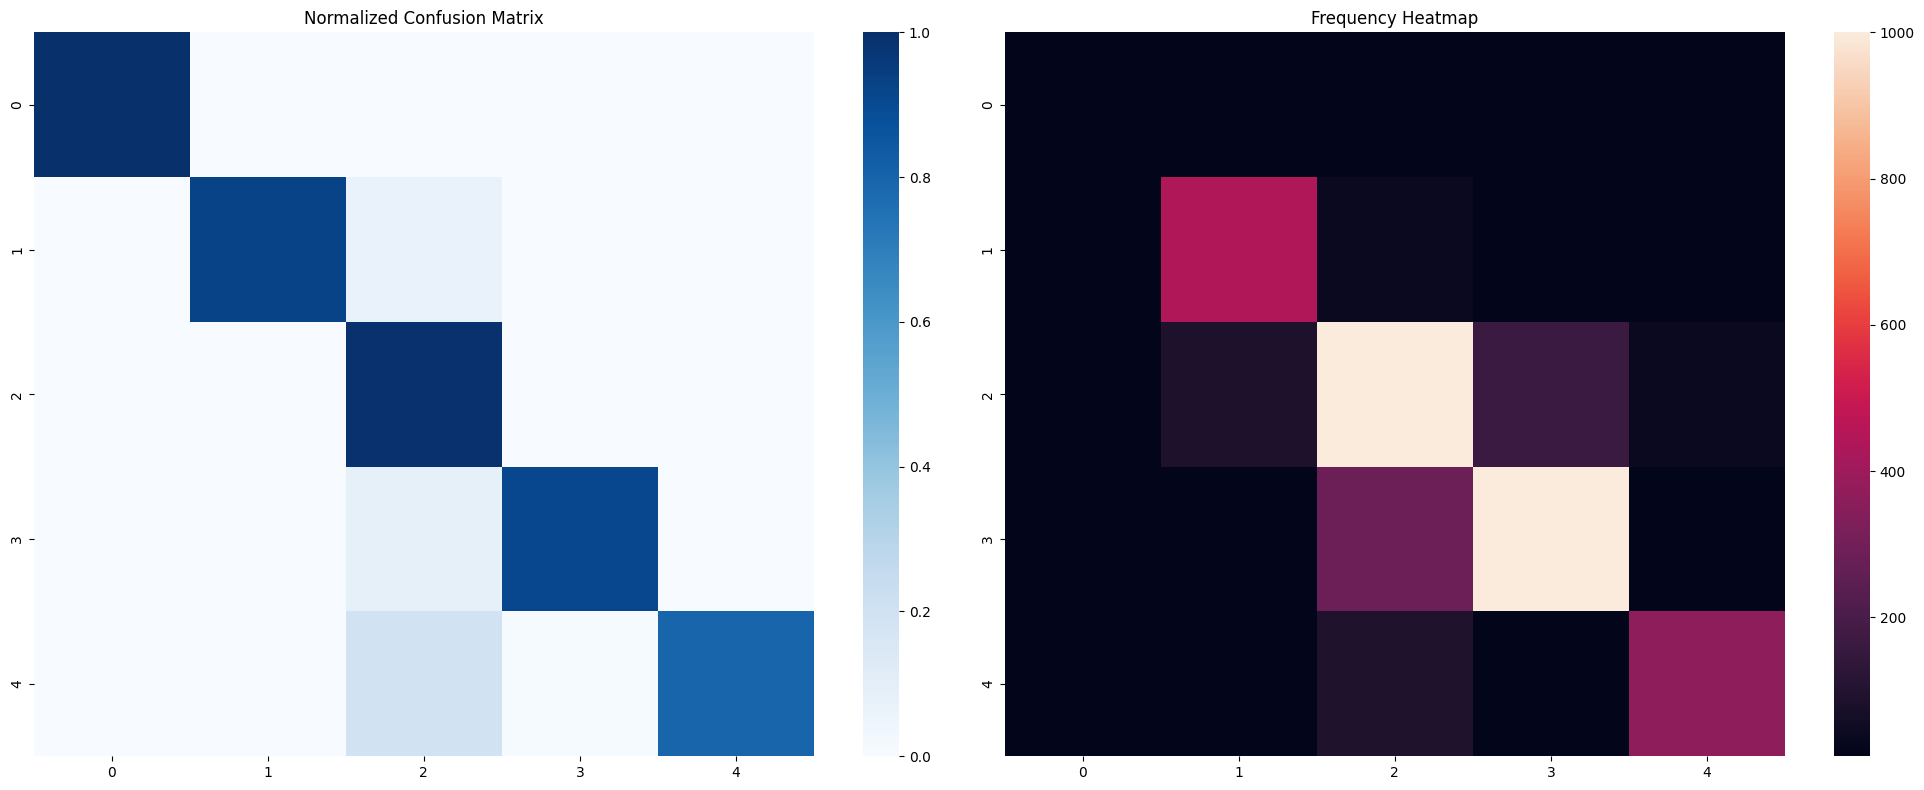

In [199]:
plot_confusion_matrix(bmccb['true_labels'], bmccb['predictions'], n_classes=5)

#### Conformal Prediction

In [68]:
X_calib_21, X_test_21, y_calib_21, y_test_21 = train_test_split(
    X_valid_21, y_valid_21, test_size=0.5, random_state=RANDOM_SEED
)

calib_21_dataset = TextDataset(X_calib_21, y_calib_21, valid_path)
test_21_dataset = TextDataset(X_test_21, y_test_21, valid_path)
calib_21_dataloader = DataLoader(calib_21_dataset, batch_size=16, shuffle=False)
test_21_dataloader = DataLoader(test_21_dataset, batch_size=16, shuffle=False)

In [240]:
# Calibration
calib_21_probs = []
calib_21_preds = []
calib_21_true = []

model_century_classifier.eval()

with torch.no_grad():
    for text, labels in tqdm(calib_21_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512).to(device)
        output = model_century_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        calib_21_probs.extend(probabilities.detach().cpu().numpy())
        calib_21_preds.extend(predictions.detach().cpu().numpy())
        calib_21_true.extend(labels.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [20:27<00:00,  1.39it/s]


In [242]:
# Group calibration data by true class
class_nonconformity_21_old = {class_idx: [] for class_idx in range(5)}

# Compute class-specific nonconformity scores
for i, (prob, true_label) in enumerate(zip(calib_21_probs, calib_21_true)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_21_old[true_label].append(nonconformity)

# Calculate threshold for each class
class_thresholds_21_old = {}
confidence_level = 0.90
alpha = 1 - confidence_level

n_samples = len(calib_21_true)
for class_idx, scores in class_nonconformity_21_old.items():
    q = np.ceil((n_samples + 1) * (1 - alpha)) / n_samples # corrected formula
    class_thresholds_21_old[class_idx] = np.quantile(scores, q)   

In [241]:
## New

# Group calibration data by true class
class_nonconformity_21 = {class_idx: [] for class_idx in range(5)}

# Compute class-specific nonconformity scores
for i, (prob, true_label) in enumerate(zip(calib_21_probs, calib_21_true)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_21[true_label].append(nonconformity)

# Calculate threshold for each class
class_thresholds_21 = {}
confidence_level = 0.90
alpha = 1 - confidence_level
    
for class_idx, scores in class_nonconformity_21.items():
    n_class_samples = len(scores)  # Use class-specific count
    q = np.ceil((n_class_samples + 1) * (1 - alpha)) / n_class_samples
    class_thresholds_21[class_idx] = np.quantile(scores, q)

In [250]:
model_century_classifier

CenturyClassifier(
  (bert): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Line

In [243]:
# New
test_preds_21 = []
test_intervals_21 = []
test_true_21 = []
test_probs_21 = []

with torch.no_grad():
    for text, labels in tqdm(test_21_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512).to(device)
        output = model_century_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)      
        for i, prob in enumerate(probabilities): # Iterate on the batch
            pred = predictions[i].item()
            true_label = labels[i].item()          
            # Create prediction set using class-specific thresholds
            prediction_set = []
            for label in range(5):
                # For each potential label, check if its nonconformity score is below the threshold
                nonconformity = 1 - prob[label].item()
                if nonconformity <= class_thresholds_21[label]:
                    prediction_set.append(label)
                    
            test_preds_21.append(pred)
            test_intervals_21.append(prediction_set)
            test_true_21.append(true_label)
            test_probs_21.append(prob.detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [20:31<00:00,  1.39it/s]


In [249]:
test_preds_argmax_21 = []       # Traditional argmax (most probable class)
test_preds_argmax_int_21 = []   # Argmax restricted to the prediction set
test_preds_margin_21 = []       # Max margin from threshold in prediction set
test_preds_rel_margin_21 = []   # Max relative margin from threshold in prediction set
test_true_var_21 = []

for idx, tidx in enumerate(X_test_21):
    tidx = int(tidx.replace('valid_text', '').replace('.txt', ''))
    
    # if tidx in blacklist_valid:
    #    continue
    intervals = test_intervals_21[idx]  # Classes in the prediction set
    true_label = test_true_21[idx]
    probs = test_probs_21[idx]
    
    # Standard argmax prediction (baseline)
    argmax_pred = np.argmax(probs)
    test_preds_argmax_21.append(argmax_pred)
    
    # If prediction set is empty use argmax
    if len(intervals) == 0:
        test_preds_argmax_int_21.append(argmax_pred)
        test_preds_margin_21.append(argmax_pred)
        test_preds_rel_margin_21.append(argmax_pred)
        test_true_var_21.append(true_label)
        continue
    
    # Argmax restricted to prediction set
    interval_probs = {label: probs[label] for label in intervals}
    argmax_int_pred = max(interval_probs, key=interval_probs.get)
    test_preds_argmax_int_21.append(argmax_int_pred)
    
    # Maximum margin from threshold
    margins = {}
    rel_margins = {}
    for label in intervals:
        nonconformity = 1 - probs[label]
        margin = class_thresholds_21[label] - nonconformity  # How far below threshold
        margins[label] = margin
        # Relative margin (normalized by threshold)
        rel_margin = margin / class_thresholds_21[label] if class_thresholds_21[label] > 0 else 0
        rel_margins[label] = rel_margin
    
    margin_pred = max(margins, key=margins.get)
    rel_margin_pred = max(rel_margins, key=rel_margins.get)
    
    test_preds_margin_21.append(margin_pred)
    test_preds_rel_margin_21.append(rel_margin_pred)
    test_true_var_21.append(true_label)

print(f"argmax (MAE): {mean_avg_error(np.array(test_true_var_21), np.array(test_preds_argmax_21))}")
print(f"argmax restricted to prediction set (MAE): {mean_avg_error(np.array(test_true_var_21), np.array(test_preds_argmax_int_21))}")
print(f"max margin (MAE): {mean_avg_error(np.array(test_true_var_21), np.array(test_preds_margin_21))}")
print(f"max relative margin (MAE): {mean_avg_error(np.array(test_true_var_21), np.array(test_preds_rel_margin_21))}")

# Calculate prediction set size statistics
set_sizes = [len(intervals) for intervals in test_intervals_21]
avg_set_size = np.mean(set_sizes)
coverage = np.mean([true_label in intervals for true_label, intervals in zip(test_true_21, test_intervals_21)])

print("----"*33)
print(f"Average prediction set size: {avg_set_size:.2f}")
print(f"Empirical coverage: {coverage:.4f} (target: {confidence_level:.4f})")

argmax (MAE): 1.7800263485325332
argmax restricted to prediction set (MAE): 1.6900387908951182
max margin (MAE): 1.1983458976798653
max relative margin (MAE): 1.1521261801946865
------------------------------------------------------------------------------------------------------------------------------------
Average prediction set size: 3.80
Empirical coverage: 0.8986 (target: 0.9000)


In [218]:
test_preds_21_old = []
test_intervals_21_old = []
test_true_21_old = []
test_probs_21_old = []

with torch.no_grad():
    for text, labels in tqdm(test_21_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512).to(device)
        output = model_century_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)      
        for i, prob in enumerate(probabilities): # Iterate on the batch
            pred = predictions[i].item()
            true_label = labels[i].item()          
            # Create prediction set using class-specific thresholds
            prediction_set = []
            for label in range(5):
                # Use threshold specific to the candidate class
                if 1 - prob[label].item() <= class_thresholds_21_old[label]:
                    prediction_set.append(label)  
                    
            test_preds_21_old.append(pred)
            test_intervals_21_old.append(prediction_set)
            test_true_21_old.append(true_label)
            test_probs_21_old.append(prob.detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [20:28<00:00,  1.39it/s]


In [222]:
test_preds_argmax_21_old = []
test_preds_argmax_int_21_old = []
test_preds_var_21_old = []
test_preds_var_rel_21_old = []


test_true_var_21_old = []
thslds_21_old = [ 1 - x for x in class_thresholds_21_old.values()]

#for idx in range(len(test_probs_21)):
for idx, tidx in enumerate(X_test_21):
    
    tidx = int(tidx.replace('valid_text', '').replace('.txt', ''))
    # if tidx in blacklist_valid:
    #    continue
    
    intervals = test_intervals_21_old[idx]
    #if len(intervals) != 1:
    #    continue
    true_label = test_true_21_old[idx]
    probs = test_probs_21_old[idx]
    
    exeeding_argmax = np.zeros(5)
    exeeding_idx = np.zeros(5)
    exeeding_rel_idx = np.zeros(5)
    
    for interval in intervals:
        if probs[interval] > thslds_21_old[interval]:
            
            exeeding_argmax[interval] = probs[interval]
            
            exeeding_idx[interval] = abs(probs[interval]-thslds_21_old[interval])
            
            exeeding_rel_idx[interval] = abs(probs[interval]-thslds_21_old[interval]) / (1-thslds_21_old[interval]) #thslds_21[interval] #probs[interval]
            
    test_preds_argmax_21_old.append(np.argmax(probs))
    test_preds_argmax_int_21_old.append(np.argmax(exeeding_argmax))
    test_preds_var_21_old.append(np.argmax(exeeding_idx))
    test_preds_var_rel_21_old.append(np.argmax(exeeding_rel_idx))
    
    test_true_var_21_old.append(true_label)
    
print(f"argmax (MAE): {mean_avg_error(np.array(test_true_var_21_old), np.array(test_preds_argmax_21_old))}")
print(f"argmax int (MAE): {mean_avg_error(np.array(test_true_var_21_old), np.array(test_preds_argmax_int_21_old))}")
print(f"variance (MAE): {mean_avg_error(np.array(test_true_var_21_old), np.array(test_preds_var_21_old))}")
print(f"variance rel (MAE): {mean_avg_error(np.array(test_true_var_21_old), np.array(test_preds_var_rel_21_old))}")

# Calculate prediction set size statistics
set_sizes = [len(intervals) for intervals in test_intervals_21_old]
avg_set_size = np.mean(set_sizes)
coverage = np.mean([true_label in intervals for true_label, intervals in zip(test_true_21, test_intervals_21_old)])

print("----"*33)
print(f"Average prediction set size: {avg_set_size:.2f}")
print(f"Empirical coverage: {coverage:.4f} (target: {confidence_level:.4f})")

argmax (MAE): 1.6773768572055918
argmax int (MAE): 1.6777794042304033
variance (MAE): 1.480750933177194
variance rel (MAE): 1.5050135402181073
------------------------------------------------------------------------------------------------------------------------------------
Average prediction set size: 2.95
Empirical coverage: 0.1531 (target: 0.9000)


In [245]:
table_data = []


# Argmax model
overall_mae_base = mean_avg_error(np.array(test_true_var_21), np.array(test_preds_argmax_21))
class_maes_base = compute_class_mae(test_true_var_21, test_preds_argmax_21)
class_freqs_base = count_class_frequencies(test_true_var_21)
argmax_row = ["argmax", f"{overall_mae_base:.4f} [{len(test_true_var_21)}]"]
for i, mae in enumerate(class_maes_base):
    argmax_row.append(f"{mae:.4f} [{class_freqs_base[i]}]")
table_data.append(argmax_row)

# Argmax int model
overall_mae_base = mean_avg_error(np.array(test_true_var_21), np.array(test_preds_argmax_int_21))
class_maes_base = compute_class_mae(test_true_var_21, test_preds_argmax_int_21)
class_freqs_base = count_class_frequencies(test_true_var_21)
argmax_int_row = ["argmax interval", f"{overall_mae_base:.4f} [{len(test_true_var_21)}]"]
for i, mae in enumerate(class_maes_base):
    argmax_int_row.append(f"{mae:.4f} [{class_freqs_base[i]}]")
table_data.append(argmax_int_row)

# Variance model
overall_mae_base = mean_avg_error(np.array(test_true_var_21), np.array(test_preds_var_21))
class_maes_base = compute_class_mae(test_true_var_21, test_preds_var_21)
class_freqs_base = count_class_frequencies(test_true_var_21)
var_row = ["var", f"{overall_mae_base:.4f} [{len(test_true_var_21)}]"]
for i, mae in enumerate(class_maes_base):
    var_row.append(f"{mae:.4f} [{class_freqs_base[i]}]")
table_data.append(var_row)

# Var rel model
overall_mae_base = mean_avg_error(np.array(test_true_var_21), np.array(test_preds_var_rel_21))
class_maes_base = compute_class_mae(test_true_var_21, test_preds_var_rel_21)
class_freqs_base = count_class_frequencies(test_true_var_21)
var_rel_row = ["var rel", f"{overall_mae_base:.4f} [{len(test_true_var_21)}]"]
for i, mae in enumerate(class_maes_base):
    var_rel_row.append(f"{mae:.4f} [{class_freqs_base[i]}]")
table_data.append(var_rel_row)

print(tabulate(table_data,
               ["Mode", "Overall MAE", "Century 0", "Century 1", "Century 2", "Century 3", "Century 4"], 
               tablefmt="grid"))

+-----------------+----------------+---------------+---------------+----------------+---------------+--------------+
| Mode            | Overall MAE    | Century 0     | Century 1     | Century 2      | Century 3     | Century 4    |
+=================+================+===============+===============+================+===============+==============+
| argmax          | 1.7800 [27326] | 0.1340 [1508] | 0.8166 [1696] | 1.8612 [22243] | 2.9122 [1652] | 3.7225 [227] |
+-----------------+----------------+---------------+---------------+----------------+---------------+--------------+
| argmax interval | 1.6900 [27326] | 0.1492 [1508] | 0.8107 [1696] | 1.8538 [22243] | 1.6120 [1652] | 3.0220 [227] |
+-----------------+----------------+---------------+---------------+----------------+---------------+--------------+
| var             | 1.4726 [27326] | 0.5955 [1508] | 0.7936 [1696] | 1.5093 [22243] | 2.2639 [1652] | 3.0176 [227] |
+-----------------+----------------+---------------+------------

[0] Pred: 0 - True 2
[0, 1, 2, 4]
Var: 0
Var rel: 0


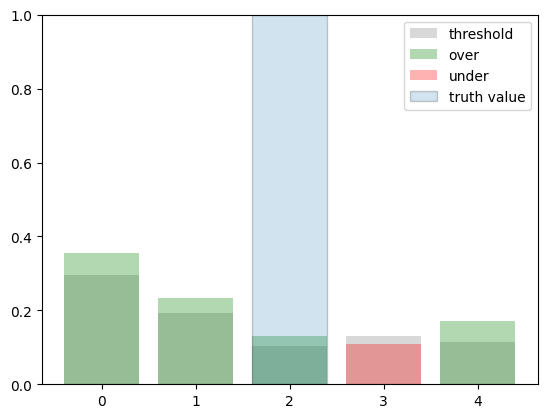

[1] Pred: 1 - True 2
[1, 2, 4]
Var: 0
Var rel: 0


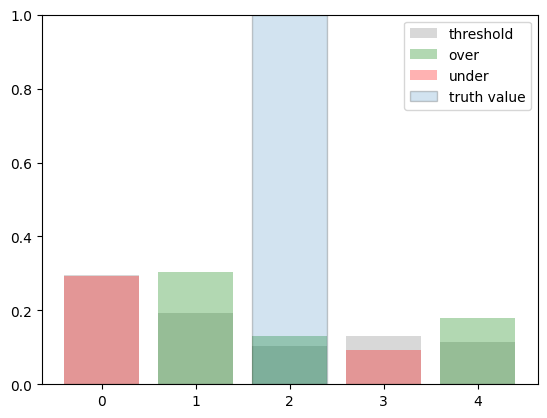

[2] Pred: 0 - True 2
[0, 1, 2, 4]
Var: 1
Var rel: 1


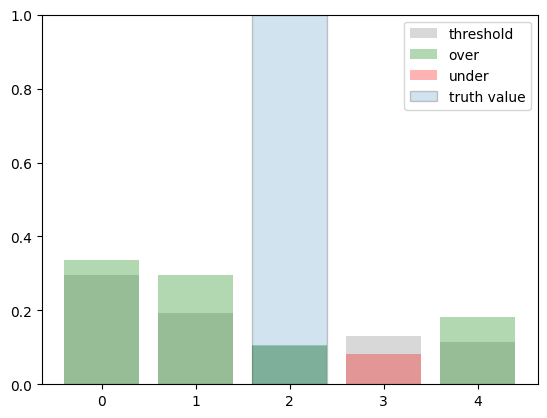

[3] Pred: 0 - True 2
[0, 1, 2, 4]
Var: 0
Var rel: 0


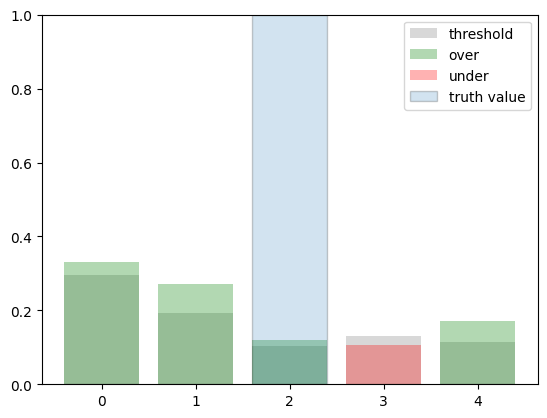

[4] Pred: 0 - True 2
[0, 1, 2, 4]
Var: 0
Var rel: 0


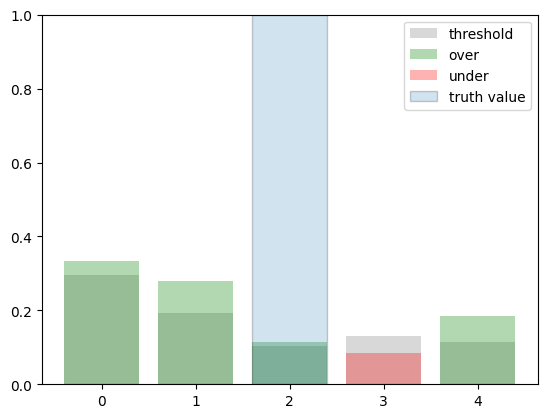

[5] Pred: 0 - True 2
[0, 1, 2, 4]
Var: 1
Var rel: 1


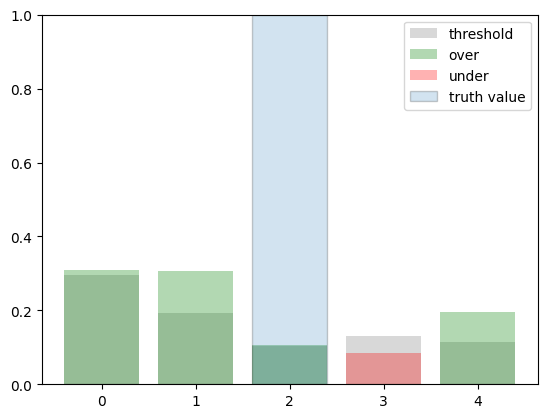

[6] Pred: 0 - True 2
[0, 1, 2, 4]
Var: 1
Var rel: 1


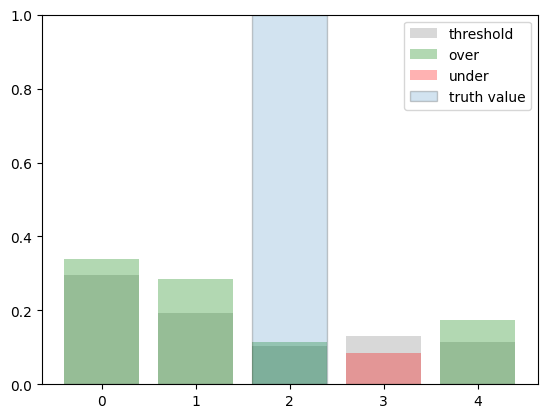

[7] Pred: 0 - True 2
[0, 1, 2, 4]
Var: 0
Var rel: 0


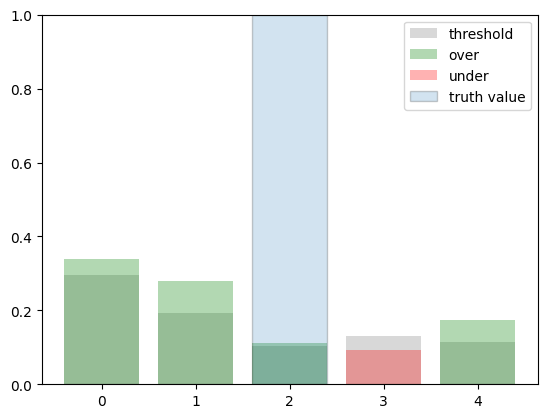

[8] Pred: 0 - True 2
[0, 1, 2, 4]
Var: 0
Var rel: 0


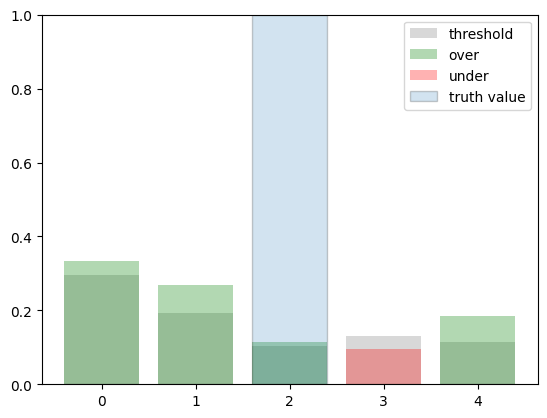

[9] Pred: 0 - True 2
[0, 1, 2, 4]
Var: 1
Var rel: 1


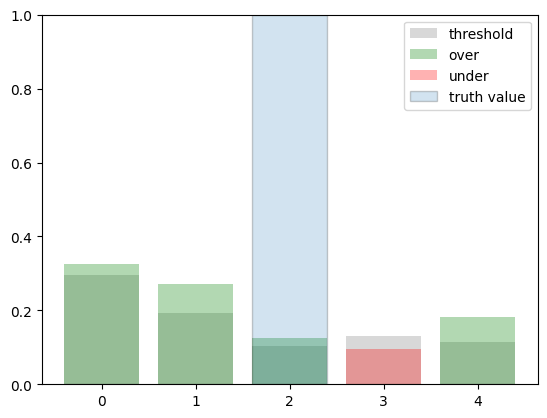

In [247]:
limit = 10
for idx in range(len(test_probs_21)):
    ex_prob = test_probs_21[idx]
    #if np.argmax(ex_prob) == test_true_21[idx]:
    #    continue
        
    # if abs(np.argmax(ex_prob) - test_true_21[idx]) < 2:
    #    continue
    tidx = X_test_21[idx]
    tidx = int(tidx.replace('valid_text', '').replace('.txt', ''))
    if tidx in blacklist_valid:
        print('ok')
        continue
    
    print(f"[{idx}] Pred: {test_preds_argmax_int_21[idx]} - True {test_true_21[idx]}")
    print(test_intervals_21[idx])
    print(f"Var: {test_preds_var_21[idx]}")
    print(f"Var rel: {test_preds_var_rel_21[idx]}")
    oks = [ x if 1 - x <= y else 0  for x, y in zip(ex_prob, class_thresholds_21.values()) ]
    not_oks = [ x if 1 - x > y else 0  for x, y in zip(ex_prob, class_thresholds_21.values()) ]

    plt.bar(class_thresholds_21.keys(), [ 1 - x for x in class_thresholds_21.values()], color='grey', alpha=0.3, label='threshold')
    #plt.bar(range(43), ex_prob, alpha=0.3)
    plt.bar(range(5), oks, alpha=0.3, color='green', label='over')
    plt.bar(range(5), not_oks, alpha=0.3, color='red', label='under')
    
    gt = np.zeros(5)
    gt[test_true_21[idx]] = 1
    plt.bar(range(5), gt, alpha=0.2, edgecolor='black', label='truth value')
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    
    limit -= 1
    if limit == 0:
        break

## Decade

In [131]:
class DecadeClassifier(nn.Module):
    def __init__(self, century_model, num_decades=10):
        super(DecadeClassifier, self).__init__()
       
        self.bert = century_model.bert
        
        for param in self.bert.parameters():
            param.requires_grad = False
            
        self.dropout = nn.Dropout(0.1)
        
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_decades)
        self.century_to_decade = nn.Linear(5, num_decades)
        
    def forward(self, input_ids, attention_mask, century_logits=None, token_type_ids=None):
        
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        
        
        decade_logits = self.classifier(pooled_output)
        
        if century_logits is not None:
            century_contribution = self.century_to_decade(century_logits)
            decade_logits = decade_logits + century_contribution
            
        return decade_logits

### Evaluation

In [137]:
# Base model

model_century_classifier = CenturyClassifier(model, 5)
model_century_classifier.load_state_dict(torch.load('models/task21/century_classifier_weights_3.pt'))
model_century_classifier.to(device)

model_decade_classifier = DecadeClassifier(model_century_classifier)
model_decade_classifier.load_state_dict(torch.load('models/task22/decade_classifier_weights_3_frozen.pt'))
model_decade_classifier.to(device)

model_century_classifier_blk = CenturyClassifier(model, 5)
model_century_classifier_blk.load_state_dict(torch.load('models/task21/century_classifier_weights_3_blacklist.pt'))
model_century_classifier_blk.to(device)

model_decade_classifier_blk = DecadeClassifier(model_century_classifier_blk)
model_decade_classifier_blk.load_state_dict(torch.load('models/task22/decade_classifier_weights_3_blacklist_frozen.pt'))
model_decade_classifier_blk.to(device)

print('Model loaded!')

Model loaded!


#### Standrard

In [136]:
y_test_pred_22 = []
y_test_true_22 = []

with torch.no_grad():
    for text, labels in tqdm(valid22_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3,).to(device)
        output = model_decade_classifier(**tokens)
        predictions = output.argmax(dim=1)
        y_test_pred_22.extend(predictions.detach().cpu().numpy())
        y_test_true_22.extend(labels.cpu().numpy())
        
print(f"MAE (without CP) [All]: {mean_avg_error(np.array(y_test_true_22), np.array(y_test_pred_22))}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3416/3416 [38:02<00:00,  1.50it/s]

MAE (without CP) [All]: 2.545900349490403


In [138]:
y_test_pred_22_blk = []
y_test_true_22_blk = []

with torch.no_grad():
    for text, labels in tqdm(valid22_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3,).to(device)
        output = model_decade_classifier_blk(**tokens)
        predictions = output.argmax(dim=1)
        y_test_pred_22_blk.extend(predictions.detach().cpu().numpy())
        y_test_true_22_blk.extend(labels.cpu().numpy())
        
print(f"MAE (without CP) [All]: {mean_avg_error(np.array(y_test_true_22_blk), np.array(y_test_pred_22_blk))}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3416/3416 [38:01<00:00,  1.50it/s]

MAE (without CP) [All]: 2.508261513970467


#### Confromal 

In [139]:
X_calib_22, X_test_22, y_calib_22, y_test_22 = train_test_split(
    X_valid_22, y_valid_22, test_size=0.5, random_state=RANDOM_SEED
)

calib_22_dataset = TextDataset(X_calib_22, y_calib_22, valid_path)
test_22_dataset = TextDataset(X_test_22, y_test_22, valid_path)
calib_22_dataloader = DataLoader(calib_22_dataset, batch_size=16, shuffle=False)
test_22_dataloader = DataLoader(test_22_dataset, batch_size=16, shuffle=False)

In [140]:
# Calibration
calib_22_probs = []
calib_22_preds = []
calib_22_true = []

model_decade_classifier.eval()

with torch.no_grad():
    for text, labels in tqdm(calib_22_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        calib_22_probs.extend(probabilities.detach().cpu().numpy())
        calib_22_preds.extend(predictions.detach().cpu().numpy())
        calib_22_true.extend(labels.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [18:53<00:00,  1.51it/s]


In [142]:
# Group calibration data by true class
class_nonconformity_22 = {class_idx: [] for class_idx in range(10)}

# Compute class-specific nonconformity scores
for i, (prob, true_label) in enumerate(zip(calib_22_probs, calib_22_true)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_22[true_label].append(nonconformity)

# Calculate threshold for each class
class_thresholds_22 = {}
confidence_level = 0.90
alpha = 1 - confidence_level

n_samples = len(calib_22_true)
for class_idx, scores in class_nonconformity_22.items():
    q = np.ceil((n_samples + 1) * (1 - alpha)) / n_samples # corrected formula
    class_thresholds_22[class_idx] = np.quantile(scores, q)   

In [143]:
test_preds_22 = []
test_intervals_22 = []
test_true_22 = []
test_probs_22 = []

with torch.no_grad():
    for text, labels in tqdm(test_22_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)      
        for i, prob in enumerate(probabilities): # Iterate on the batch
            pred = predictions[i].item()
            true_label = labels[i].item()          
            # Create prediction set using class-specific thresholds
            prediction_set = []
            for label in range(10):
                # Use threshold specific to the candidate class
                if 1 - prob[label].item() <= class_thresholds_22[label]:
                    prediction_set.append(label)  
                    
            test_preds_22.append(pred)
            test_intervals_22.append(prediction_set)
            test_true_22.append(true_label)
            test_probs_22.append(prob.detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [18:57<00:00,  1.50it/s]


In [144]:
test_preds_argmax_22 = []
test_preds_argmax_int_22 = []
test_preds_var_22 = []
test_preds_var_rel_22 = []


test_true_var_22 = []
thslds_22 = [ 1 - x for x in class_thresholds_22.values()]

#for idx in range(len(test_probs_21)):
for idx, tidx in enumerate(X_test_22):
    
    tidx = int(tidx.replace('valid_text', '').replace('.txt', ''))
    # if tidx in blacklist_valid:
    #    continue
    
    intervals = test_intervals_22[idx]
    #if len(intervals) != 1:
    #    continue
    true_label = test_true_22[idx]
    probs = test_probs_22[idx]
    
    exeeding_argmax = np.zeros(10)
    exeeding_idx = np.zeros(10)
    exeeding_rel_idx = np.zeros(10)
    
    for interval in intervals:
        if probs[interval] > thslds_22[interval]:
            
            exeeding_argmax[interval] = probs[interval]
            
            exeeding_idx[interval] = abs(probs[interval]-thslds_22[interval])
            
            exeeding_rel_idx[interval] = abs(probs[interval]-thslds_22[interval]) / (1-thslds_22[interval]) #thslds_21[interval] #probs[interval]
            
    test_preds_argmax_22.append(np.argmax(probs))
    test_preds_argmax_int_22.append(np.argmax(exeeding_argmax))
    test_preds_var_22.append(np.argmax(exeeding_idx))
    test_preds_var_rel_22.append(np.argmax(exeeding_rel_idx))
    
    test_true_var_22.append(true_label)
    
print(f"argmax (MAE): {mean_avg_error(np.array(test_true_var_22), np.array(test_preds_argmax_22))}")
print(f"argmax int (MAE): {mean_avg_error(np.array(test_true_var_22), np.array(test_preds_argmax_int_22))}")
print(f"variance (MAE): {mean_avg_error(np.array(test_true_var_22), np.array(test_preds_var_22))}")
print(f"variance rel (MAE): {mean_avg_error(np.array(test_true_var_22), np.array(test_preds_var_rel_22))}")

argmax (MAE): 2.56367562028837
argmax int (MAE): 2.53004464612457
variance (MAE): 2.703944960843153
variance rel (MAE): 2.696735709580619


In [154]:
table_data = []


# Argmax model
overall_mae_base = mean_avg_error(np.array(test_true_var_22), np.array(test_preds_argmax_22))
class_maes_base = compute_class_mae(test_true_var_22, test_preds_argmax_22, n_classes=10)
class_freqs_base = count_class_frequencies(test_true_var_22, n_classes=10)
argmax_row = ["argmax", f"{overall_mae_base:.3f} [{len(test_true_var_22)}]"]
for i, mae in enumerate(class_maes_base):
    # argmax_row.append(f"{mae:.3f} [{class_freqs_base[i]}]")
    argmax_row.append(f"{mae:.3f}")
    
table_data.append(argmax_row)

# Argmax int model
overall_mae_base = mean_avg_error(np.array(test_true_var_22), np.array(test_preds_argmax_int_22))
class_maes_base = compute_class_mae(test_true_var_22, test_preds_argmax_int_22, n_classes=10)
class_freqs_base = count_class_frequencies(test_true_var_22, n_classes=10)
argmax_int_row = ["[CP] argmax", f"{overall_mae_base:.3f} [{len(test_true_var_22)}]"]
for i, mae in enumerate(class_maes_base):
    # argmax_int_row.append(f"{mae:.3f} [{class_freqs_base[i]}]")
    argmax_int_row.append(f"{mae:.3f}")
table_data.append(argmax_int_row)

# Variance model
overall_mae_base = mean_avg_error(np.array(test_true_var_22), np.array(test_preds_var_22))
class_maes_base = compute_class_mae(test_true_var_22, test_preds_var_22, n_classes=10)
class_freqs_base = count_class_frequencies(test_true_var_22, n_classes=10)
var_row = ["[CP] var", f"{overall_mae_base:.3f} [{len(test_true_var_22)}]"]
for i, mae in enumerate(class_maes_base):
    # var_row.append(f"{mae:.3f} [{class_freqs_base[i]}]")
    var_row.append(f"{mae:.3f}")
table_data.append(var_row)

# Var rel model
overall_mae_base = mean_avg_error(np.array(test_true_var_22), np.array(test_preds_var_rel_22))
class_maes_base = compute_class_mae(test_true_var_22, test_preds_var_rel_22, n_classes=10)
class_freqs_base = count_class_frequencies(test_true_var_22, n_classes=10)
var_rel_row = ["[CP] var rel", f"{overall_mae_base:.3f} [{len(test_true_var_22)}]"]
for i, mae in enumerate(class_maes_base):
    # var_rel_row.append(f"{mae:.3f} [{class_freqs_base[i]}]")
    var_rel_row.append(f"{mae:.3f}")

table_data.append(var_rel_row)

print(tabulate(table_data,
               ["Mode", "Overall MAE", "Decade 0", "Decade 1", "Decade 2", "Decade 3", "Decade 4", "Decade 5"
               , "Decade 6", "Decade 7", "Decade 8", "Decade 9"], 
               tablefmt="grid"))

+--------------+---------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
| Mode         | Overall MAE   |   Decade 0 |   Decade 1 |   Decade 2 |   Decade 3 |   Decade 4 |   Decade 5 |   Decade 6 |   Decade 7 |   Decade 8 |   Decade 9 |
+==============+===============+============+============+============+============+============+============+============+============+============+============+
| argmax       | 2.564 [27326] |      7.451 |      6.693 |      5.97  |      5.035 |      4.046 |      2.996 |      2.083 |      1.151 |      0.337 |      1.134 |
+--------------+---------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
| [CP] argmax  | 2.530 [27326] |      7.195 |      6.416 |      5.847 |      5.014 |      4.035 |      2.984 |      2.085 |      1.155 |      0.345 |      1.147 |
+--------------+------

# Single model

In [75]:
import torch
import torch.nn as nn
from transformers import LongformerModel, LongformerTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class MultiTaskLongformerModel(nn.Module):
    def __init__(self):
        super(MultiTaskLongformerModel, self).__init__()
        
        # Load pre-trained Longformer
        self.longformer = LongformerModel.from_pretrained('allenai/longformer-base-4096')
        
        # Freeze base Longformer layers (optional)
        for param in self.longformer.parameters():
            param.requires_grad = False
        
        # Classifier heads for each task
        self.century_classifier = nn.Sequential(
            nn.Linear(self.longformer.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 5)
        )
        
        self.decade_classifier = nn.Sequential(
            nn.Linear(self.longformer.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 10)
        )
    
    def forward(self, input_ids, attention_mask):
        # Get Longformer embeddings
        outputs = self.longformer(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        
        # Use the [CLS] token representation
        pooled_output = outputs.last_hidden_state[:, 0, :]
        
        # Task-specific predictions
        century_logits = self.century_classifier(pooled_output)
        decade_logits = self.decade_classifier(pooled_output)
        
        return century_logits, decade_logits


def multi_task_loss(century_logits, decade_logits, 
                    century_labels, decade_labels, 
                    century_weight=0.5, decade_weight=0.5):
    century_loss = nn.CrossEntropyLoss()(century_logits, century_labels)
    decade_loss = nn.CrossEntropyLoss()(decade_logits, decade_labels)

    return century_weight * century_loss + decade_weight * decade_loss

def train_multi_task_model(model, train_loader, val_loader, epochs=3):
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    
    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            
            # Forward pass
            century_logits, decade_logits = model(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask']
            )
            
            # Compute loss
            loss = multi_task_loss(
                century_logits, decade_logits, 
                batch['century_labels'], batch['decade_labels']
            )
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_century_accuracy = evaluate_task(model, val_loader, task='century')
        val_decade_accuracy = evaluate_task(model, val_loader, task='decade')
        
        print(f"Epoch {epoch+1}: Century Accuracy = {val_century_accuracy}, Decade Accuracy = {val_decade_accuracy}")

def evaluate_task(model, dataloader, task='century'):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in dataloader:
            century_logits, decade_logits = model(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask']
            )
            
            if task == 'century':
                predictions = torch.argmax(century_logits, dim=1)
                correct_predictions += (predictions == batch['century_labels']).sum().item()
            else:
                predictions = torch.argmax(decade_logits, dim=1)
                correct_predictions += (predictions == batch['decade_labels']).sum().item()
            
            total_predictions += len(predictions)
    
    return correct_predictions / total_predictions

# Best practices for improving accuracy
def improve_accuracy_strategies():
    """
    Strategies to improve multi-task Longformer model accuracy:
    1. Data Augmentation
    2. Hyperparameter Tuning
    3. Cross-Validation
    4. Transfer Learning
    5. Weighted Loss Function
    """
    pass

In [66]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import LongformerTokenizer
from sklearn.model_selection import train_test_split
import os

class FileBasedMultiTaskDataset(Dataset):
    def __init__(self, file_paths, path, century_labels, decade_labels, tokenizer, max_length=512):
        """
        Custom dataset for multi-task text classification using file paths
        
        Args:
            file_paths: List of paths to text files
            century_labels: List of century labels (integers)
            decade_labels: List of decade labels (integers)
            tokenizer: Longformer tokenizer
            max_length: Maximum sequence length
        """
        self.file_paths = file_paths
        self.path = path
        self.century_labels = century_labels
        self.decade_labels = decade_labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        century_label = self.century_labels[idx]
        decade_label = self.decade_labels[idx]
        
        # Read the text from file
        with open(os.path.join(self.path, file_path), 'r', encoding='utf-8') as f:
            text = f.read()
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Remove the batch dimension the tokenizer adds
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        
        # Add labels
        encoding['century_labels'] = torch.tensor(century_label, dtype=torch.long)
        encoding['decade_labels'] = torch.tensor(decade_label, dtype=torch.long)
        
        return encoding

In [88]:
train2X = FileBasedMultiTaskDataset(X_train_21, train_path, y_train_21, y_train_22, tokenizer)
valid2X = FileBasedMultiTaskDataset(X_valid_21, valid_path, y_valid_21, y_valid_22, tokenizer)

train2X_dataloader = DataLoader(train2X, batch_size=batch_size, shuffle=True)
valid2X_dataloader = DataLoader(valid2X, batch_size=batch_size, shuffle=False)

In [89]:
mtlm = MultiTaskLongformerModel().to(device)

In [94]:
def evaluate_task(model, dataloader, task='century'):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            century_logits, decade_logits = model(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask']
            )
            
            if task == 'century':
                predictions = torch.argmax(century_logits, dim=1)
                correct_predictions += (predictions == batch['century_labels']).sum().item()
            else:
                predictions = torch.argmax(decade_logits, dim=1)
                correct_predictions += (predictions == batch['decade_labels']).sum().item()
            
            total_predictions += len(predictions)
    
    return correct_predictions / total_predictions

evaluate_task(mtlm, valid2X_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3416/3416 [14:58<00:00,  3.80it/s]


0.8162888144773197

In [95]:
evaluate_task(mtlm, valid2X_dataloader, task='decade')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3416/3416 [15:11<00:00,  3.75it/s]


0.2549450147298311

In [90]:
train_multi_task_model(mtlm, train2X_dataloader, valid2X_dataloader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12795/12795 [46:52<00:00,  4.55it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

# Test

In [97]:
class MultiTaskLongformerModel(nn.Module):
    def __init__(self):
        super(MultiTaskLongformerModel, self).__init__()
        
        self.longformer = LongformerModel.from_pretrained('allenai/longformer-base-4096')
        
        # for param in self.longformer.parameters():
        #     param.requires_grad = False
        
        # Century head
        self.century_classifier = nn.Sequential(
            nn.Linear(self.longformer.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 5)
        )
        
        # Decade head
        self.decade_classifier = nn.Sequential(
            nn.Linear(self.longformer.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 10)
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.longformer(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        
        pooled_output = outputs.last_hidden_state[:, 0, :]
        
        century_logits = self.century_classifier(pooled_output)
        decade_logits = self.decade_classifier(pooled_output)
        
        return century_logits, decade_logits

In [99]:
best_mtlm = MultiTaskLongformerModel()
best_mtlm.to(device)
best_mtlm.load_state_dict(torch.load('models/task2x/best_model_notf.pt'))

<All keys matched successfully>

In [100]:
class FileBasedMultiTaskDataset(Dataset):
    def __init__(self, file_paths, path, century_labels, decade_labels, tokenizer, max_length=1536):
        self.file_paths = file_paths            # file name (.txt)
        self.path = path                        # path (train/valid)
        self.century_labels = century_labels    # data21
        self.decade_labels = decade_labels      # data22
        self.tokenizer = tokenizer
        self.max_length = max_length            # default 512*3 = 1536
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        century_label = self.century_labels[idx]
        decade_label = self.decade_labels[idx]
        
        with open(os.path.join(self.path, file_path), 'r', encoding='utf-8') as f:
            text = f.read()
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        
        encoding['century_labels'] = torch.tensor(century_label, dtype=torch.long)
        encoding['decade_labels'] = torch.tensor(decade_label, dtype=torch.long)
        
        return encoding

In [101]:
test_path = './data/Task2/test'
test_files = os.listdir(test_path)
print(f"Test: {len(test_files)}")


Test: 150809


In [125]:
test2x = FileBasedMultiTaskDataset(test_files[:1036], test_path, np.zeros(len(test_files[:1036])), np.zeros(len(test_files[:1036])), tokenizer)
test2x_dataloader = DataLoader(test2x, batch_size=16, shuffle=True)

In [126]:
century_preds = []
decade_preds = []
best_mtlm.eval()
with torch.no_grad():
        for batch in tqdm(test2x_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            century_logits, decade_logits = best_mtlm(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask']
            )
            
            # Century predictions
            century_predictions = torch.argmax(century_logits, dim=1)
            century_labels = batch['century_labels']
            
            # Decade predictions
            decade_predictions = torch.argmax(decade_logits, dim=1)
            decade_labels = batch['decade_labels']
            
            century_preds.extend(century_predictions.cpu().numpy())
            decade_preds.extend(decade_predictions.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:34<00:00,  1.86it/s]


In [127]:
Counter(century_preds)

Counter({2: 1022, 1: 9, 3: 3, 4: 2})

In [155]:
X_valid_21b = []
y_valid_21b = []

for idx, row in valid21.iterrows():
    file_name = row.file_name
    century = row.century
    if idx in blacklist_valid:
        continue
    X_valid_21b.append(file_name)
    y_valid_21b.append(century-1)
    
X_valid_22b = []
y_valid_22b = []

for idx, row in valid22.iterrows():
    file_name = row.file_name
    decade = row.decade
    if idx in blacklist_valid:
        continue
    X_valid_22b.append(file_name)
    y_valid_22b.append(decade-1)
    
valid2x = FileBasedMultiTaskDataset(X_valid_21b, valid_path, y_valid_21b, y_valid_22b, tokenizer)

batch_size = 16

valid2x_dataloader = DataLoader(valid2x, batch_size=batch_size, shuffle=False)

In [156]:
century_preds = []
century_true = []
decade_preds = []
best_mtlm.eval()
with torch.no_grad():
        for batch in tqdm(valid2x_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            century_logits, decade_logits = best_mtlm(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask']
            )
            
            # Century predictions
            century_predictions = torch.argmax(century_logits, dim=1)
            century_labels = batch['century_labels']
            
            # Decade predictions
            decade_predictions = torch.argmax(decade_logits, dim=1)
            decade_labels = batch['decade_labels']
            
            century_true.extend(century_labels.cpu().numpy())
            century_preds.extend(century_predictions.cpu().numpy())
            decade_preds.extend(decade_predictions.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3025/3025 [29:08<00:00,  1.73it/s]


In [157]:
Counter(century_preds)

Counter({2: 43477, 3: 3639, 4: 818, 1: 453, 0: 13})

In [158]:
Counter(century_true)

Counter({2: 44212, 3: 3249, 1: 471, 4: 457, 0: 11})

In [139]:
def evaluate(model, dataloader):
    model.eval()
    century_correct = 0
    decade_correct = 0
    total_predictions = 0
    century_preds = []
    century_labels_list = []
    decade_preds = []
    decade_labels_list = []
    total_loss = 0
    batch_count = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            century_logits, decade_logits = model(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask']
            )
            
            # Calculate loss
            loss = multi_task_loss(
                century_logits, decade_logits, 
                batch['century_labels'], batch['decade_labels']
            )
            total_loss += loss.item()
            batch_count += 1
            
            # Century predictions
            century_predictions = torch.argmax(century_logits, dim=1)
            century_labels = batch['century_labels']
            century_correct += (century_predictions == century_labels).sum().item()
            
            # Decade predictions
            decade_predictions = torch.argmax(decade_logits, dim=1)
            decade_labels = batch['decade_labels']
            decade_correct += (decade_predictions == decade_labels).sum().item()
            
            total_predictions += len(century_predictions)
            century_preds.extend(century_predictions.cpu().numpy())
            century_labels_list.extend(century_labels.cpu().numpy())
            decade_preds.extend(decade_predictions.cpu().numpy())
            decade_labels_list.extend(decade_labels.cpu().numpy())
    
    # Calculate metrics
    average_loss = total_loss / batch_count if batch_count > 0 else float('inf')
    century_accuracy = century_correct / total_predictions
    century_mae = mean_avg_error(np.array(century_labels_list), np.array(century_preds))
    decade_accuracy = decade_correct / total_predictions
    decade_mae = mean_avg_error(np.array(decade_labels_list), np.array(decade_preds))
    
    return average_loss, century_accuracy, century_mae, decade_accuracy, decade_mae

In [140]:
evaluate(best_mtlm, valid2x_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:35<00:00,  1.77it/s]


(1.3693053755495284, 0.85, 0.234, 0.765, 0.831)

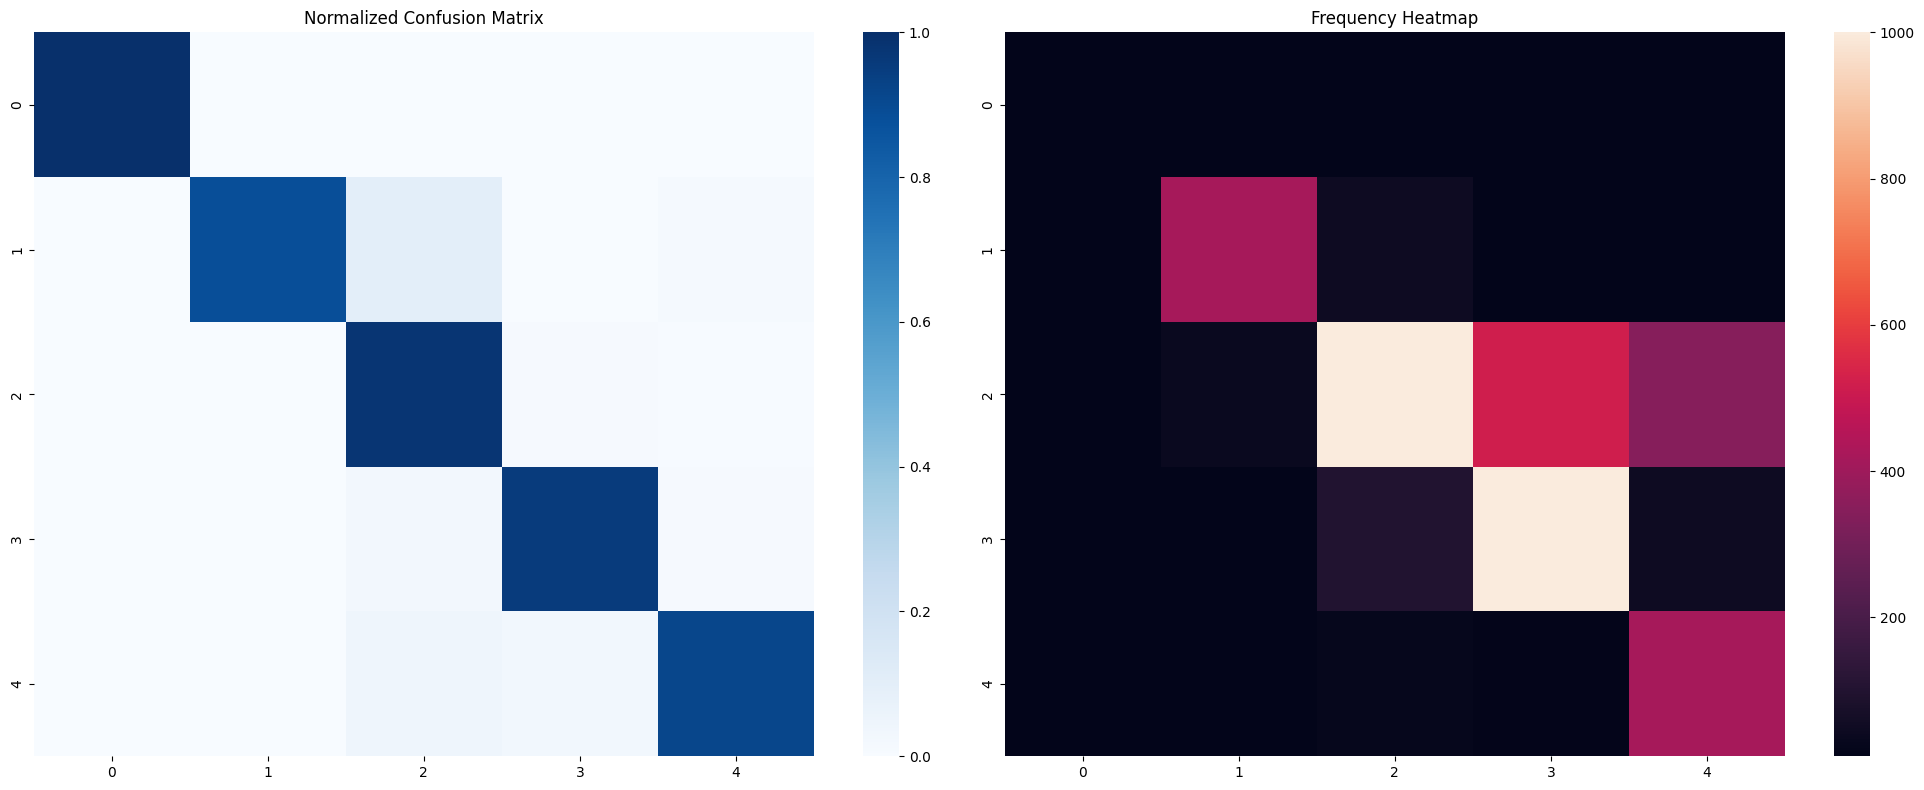

In [159]:
plot_confusion_matrix(century_true, century_preds)

In [160]:
compute_class_mae(century_true, century_preds)

[0.0,
 0.14861995753715498,
 0.028250248801230435,
 0.04462911665127731,
 0.13566739606126915]

In [169]:
res_csv = pd.DataFrame({'id': X_valid_21b, 'century_label': century_preds, 'decade_label': decade_preds})
res_csv.set_index('id', inplace=True)
res_csv.to_csv('a_sub.csv')

In [171]:
test_res_pd = pd.read_csv('submissions/multitask_argmax.csv')

In [177]:
test_res_pd.groupby('decade_label').count()

,id,century_label
decade_label,,
0,5780,5780
1,2625,2625
2,2273,2273
3,20407,20407
4,2973,2973
5,72960,72960
6,11609,11609
7,3063,3063
8,8172,8172


In [180]:
test_res_pd['decade_label'] = test_res_pd['decade_label'] + 1

In [182]:
test_res_pd.to_csv('./submissions/multitask_argmax_fix.csv', index=False)

### Conformal

In [186]:
X_calib_21b, X_test_21b, y_calib_21b, y_test_21b = train_test_split(
    X_valid_21b, y_valid_21b, test_size=0.5, random_state=RANDOM_SEED
)

calib_21_dataset = TextDataset(X_calib_21, y_calib_21, valid_path)
test_21_dataset = TextDataset(X_test_21, y_test_21, valid_path)
calib_21_dataloader = DataLoader(calib_21_dataset, batch_size=16, shuffle=False)
test_21_dataloader = DataLoader(test_21_dataset, batch_size=16, shuffle=False)

In [189]:
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

calib_2x_dataset = FileBasedMultiTaskDataset(X_calib_21b, valid_path, y_calib_21b, np.zeros(len(X_calib_21b)), tokenizer)
test_2x_dataset = FileBasedMultiTaskDataset(X_test_21b, valid_path, y_test_21b, np.zeros(len(X_test_21b)), tokenizer)
               

calib_2x_dataloader = DataLoader(calib_2x_dataset, batch_size=16, shuffle=False)
test_2x_dataloader = DataLoader(test_2x_dataset, batch_size=16, shuffle=False)

In [194]:
# Calibration
calib_2x_probs = []
calib_2x_preds = []
calib_2x_true = []

model_century_classifier.eval()

with torch.no_grad():
    for batch in tqdm(calib_2x_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        century_logits, decade_logits = best_mtlm(
            input_ids=batch['input_ids'], 
            attention_mask=batch['attention_mask']
        )

        # Century predictions
        century_predictions = torch.argmax(century_logits, dim=1)
        century_labels = batch['century_labels']

        # Decade predictions
        #decade_predictions = torch.argmax(decade_logits, dim=1)
        #decade_labels = batch['decade_labels']

        calib_2x_true.extend(century_labels.cpu().numpy())
        calib_2x_preds.extend(century_predictions.cpu().numpy())
        calib_2x_probs.extend(probabilities.detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1513/1513 [16:00<00:00,  1.58it/s]


In [200]:
class_nonconformity_2x = {class_idx: [] for class_idx in range(5)}

for i, (prob, true_label) in enumerate(zip(calib_2x_probs, calib_2x_true)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_2x[true_label].append(nonconformity)

class_thresholds_2x = {}
confidence_level = 0.90
alpha = 1 - confidence_level

for class_idx, scores in class_nonconformity_2x.items():
    n_class_samples = len(scores)  # Use class-specific count
    print('a')
    q = np.ceil((n_class_samples + 1) * (1 - alpha)) / n_class_samples
    class_thresholds_2x[class_idx] = np.quantile(scores, q)  

a


ValueError: Quantiles must be in the range [0, 1]

In [201]:
class_nonconformity_2x = {class_idx: [] for class_idx in range(5)}

for i, (prob, true_label) in enumerate(zip(calib_2x_probs, calib_2x_true)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_2x[true_label].append(nonconformity)

class_thresholds_2x = {}
confidence_level = 0.90
alpha = 1 - confidence_level

for class_idx, scores in class_nonconformity_2x.items():
    n_class_samples = len(scores)
    if n_class_samples == 0:
        # Handle empty class case
        class_thresholds_2x[class_idx] = 1.0  # Conservative default
    else:
        # Ensure q is valid (between 0 and 1)
        q_numerator = np.ceil((n_class_samples + 1) * (1 - alpha))
        if q_numerator <= n_class_samples:
            q = q_numerator / n_class_samples
            class_thresholds_2x[class_idx] = np.quantile(scores, q)
        else:
            # If n is too small for valid q, use the maximum score
            class_thresholds_2x[class_idx] = np.max(scores)

In [202]:
# New
test_preds_2x = []
test_intervals_2x = []
test_true_2x = []
test_probs_2x = []

            
with torch.no_grad():
        for batch in tqdm(test_2x_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            century_logits, decade_logits = best_mtlm(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask']
            )
            
            # Century predictions
            century_predictions = torch.argmax(century_logits, dim=1)
            century_labels = batch['century_labels']
            probabilities = torch.softmax(century_logits, dim=1)
            for i, prob in enumerate(probabilities): # Iterate on the batch
                pred = century_predictions[i].item()
                true_label = century_labels[i].item()          

                prediction_set = []
                for label in range(5):
                    nonconformity = 1 - prob[label].item()
                    if nonconformity <= class_thresholds_2x[label]:
                        prediction_set.append(label)

                test_preds_2x.append(pred)
                test_intervals_2x.append(prediction_set)
                test_true_2x.append(true_label)
                test_probs_2x.append(prob.detach().cpu().numpy())
            
            # Decade predictions
            # decade_predictions = torch.argmax(decade_logits, dim=1)
            # decade_labels = batch['decade_labels']
            
            #century_true.extend(century_labels.cpu().numpy())
            #century_preds.extend(century_predictions.cpu().numpy())
            #decade_preds.extend(decade_predictions.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1513/1513 [15:54<00:00,  1.58it/s]


In [203]:
test_preds_argmax_2x = []       # Traditional argmax (most probable class)
test_preds_argmax_int_2x = []   # Argmax restricted to the prediction set
test_preds_margin_2x = []       # Max margin from threshold in prediction set
test_preds_rel_margin_2x = []   # Max relative margin from threshold in prediction set
test_true_var_2x = []

for idx, tidx in enumerate(X_test_21b):
    tidx = int(tidx.replace('valid_text', '').replace('.txt', ''))
    
    # if tidx in blacklist_valid:
    #    continue
    intervals = test_intervals_2x[idx]  # Classes in the prediction set
    true_label = test_true_2x[idx]
    probs = test_probs_2x[idx]
    
    # Standard argmax prediction (baseline)
    argmax_pred = np.argmax(probs)
    test_preds_argmax_2x.append(argmax_pred)
    
    # If prediction set is empty use argmax
    if len(intervals) == 0:
        test_preds_argmax_int_2x.append(argmax_pred)
        test_preds_margin_2x.append(argmax_pred)
        test_preds_rel_margin_2x.append(argmax_pred)
        test_true_var_2x.append(true_label)
        continue
    
    # Argmax restricted to prediction set
    interval_probs = {label: probs[label] for label in intervals}
    argmax_int_pred = max(interval_probs, key=interval_probs.get)
    test_preds_argmax_int_2x.append(argmax_int_pred)
    
    # Maximum margin from threshold
    margins = {}
    rel_margins = {}
    for label in intervals:
        nonconformity = 1 - probs[label]
        margin = class_thresholds_2x[label] - nonconformity  # How far below threshold
        margins[label] = margin
        # Relative margin (normalized by threshold)
        rel_margin = margin / class_thresholds_2x[label] if class_thresholds_2x[label] > 0 else 0
        rel_margins[label] = rel_margin
    
    margin_pred = max(margins, key=margins.get)
    rel_margin_pred = max(rel_margins, key=rel_margins.get)
    
    test_preds_margin_2x.append(margin_pred)
    test_preds_rel_margin_2x.append(rel_margin_pred)
    test_true_var_2x.append(true_label)

print(f"argmax (MAE): {mean_avg_error(np.array(test_true_var_2x), np.array(test_preds_argmax_2x))}")
print(f"argmax restricted to prediction set (MAE): {mean_avg_error(np.array(test_true_var_2x), np.array(test_preds_argmax_int_2x))}")
print(f"max margin (MAE): {mean_avg_error(np.array(test_true_var_2x), np.array(test_preds_margin_2x))}")
print(f"max relative margin (MAE): {mean_avg_error(np.array(test_true_var_2x), np.array(test_preds_rel_margin_2x))}")

# Calculate prediction set size statistics
set_sizes = [len(intervals) for intervals in test_intervals_2x]
avg_set_size = np.mean(set_sizes)
coverage = np.mean([true_label in intervals for true_label, intervals in zip(test_true_2x, test_intervals_2x)])

print("----"*33)
print(f"Average prediction set size: {avg_set_size:.2f}")
print(f"Empirical coverage: {coverage:.4f} (target: {confidence_level:.4f})")

argmax (MAE): 0.032520661157024795
argmax restricted to prediction set (MAE): 0.05508264462809918
max margin (MAE): 0.07078512396694214
max relative margin (MAE): 0.05793388429752066
------------------------------------------------------------------------------------------------------------------------------------
Average prediction set size: 3.16
Empirical coverage: 0.9594 (target: 0.9000)


In [209]:
## Check validation
model_path = 'models/task2x/best_model_notf.pt'  # Path to multitask model
best_model = MultiTaskLongformerModel()
best_model.load_state_dict(torch.load(model_path, map_location=device))
best_model.to(device)
print()

In [221]:
evaluate2x(best_model, valid2x_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3025/3025 [29:13<00:00,  1.72it/s]


(0.2513695166637151,
 0.9764462809917356,
 0.03152892561983471,
 0.8642148760330578,
 0.37706611570247933,
 0.4435123966942149)

In [220]:
def multi_task_loss(century_logits, decade_logits, 
                    century_labels, decade_labels, 
                    century_weight=0.5, decade_weight=0.5):
    century_loss = nn.CrossEntropyLoss()(century_logits, century_labels)
    decade_loss = nn.CrossEntropyLoss()(decade_logits, decade_labels)

    return century_weight * century_loss + decade_weight * decade_loss

def evaluate2x(model, dataloader):
    model.eval()
    century_correct = 0
    decade_correct = 0
    total_predictions = 0
    century_preds = []
    century_labels_list = []
    decade_preds = []
    decade_labels_list = []
    # For calculating Final Rank
    combined_gt_values = []
    combined_pred_values = []
    total_loss = 0
    batch_count = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            century_logits, decade_logits = model(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask']
            )
            
            # Calculate loss
            loss = multi_task_loss(
                century_logits, decade_logits, 
                batch['century_labels'], batch['decade_labels']
            )
            total_loss += loss.item()
            batch_count += 1
            
            # Century predictions (classification)
            century_predictions = torch.argmax(century_logits, dim=1)
            century_labels = batch['century_labels']
            century_correct += (century_predictions == century_labels).sum().item()
            
            # Decade predictions (classification)
            decade_predictions = torch.argmax(decade_logits, dim=1)
            decade_labels = batch['decade_labels']
            decade_correct += (decade_predictions == decade_labels).sum().item()
            
            # Store predictions and labels
            total_predictions += len(century_predictions)
            century_preds.extend(century_predictions.cpu().numpy())
            century_labels_list.extend(century_labels.cpu().numpy())
            decade_preds.extend(decade_predictions.cpu().numpy())
            decade_labels_list.extend(decade_labels.cpu().numpy())
 
            combined_labels = (batch['century_labels']*10 + batch['decade_labels'])
            decade_predictions = century_predictions*10 + decade_predictions
            # For final rank computation
            combined_gt_values.extend(combined_labels.cpu().numpy())
            combined_pred_values.extend(decade_predictions.cpu().numpy())
            
    # Calculate metrics
    average_loss = total_loss / batch_count if batch_count > 0 else float('inf')
    century_accuracy = century_correct / total_predictions
    decade_accuracy = decade_correct / total_predictions
    century_mae = mean_avg_error(np.array(century_labels_list), np.array(century_preds))
    
    # For decade classification, calculate MAE between true and predicted class
    decade_mae = mean_avg_error(np.array(decade_labels_list), np.array(decade_preds))
    
    # Calculate Final Rank (FR)
    final_rank = mean_avg_error(np.array(combined_gt_values), np.array(combined_pred_values))
    
    return average_loss, century_accuracy, century_mae, decade_accuracy, decade_mae, final_rank

## Merged

In [344]:
class MultiTaskLongformerModel(nn.Module):
    def __init__(self):
        super(MultiTaskLongformerModel, self).__init__()
        
        self.longformer = LongformerModel.from_pretrained('allenai/longformer-base-4096')
        
        # Century head (classification)
        self.century_classifier = nn.Sequential(
            nn.Linear(self.longformer.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 5)
        )
        
        # Decade head (43-class classification instead of regression)
        self.decade_classifier = nn.Sequential(
            nn.Linear(self.longformer.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 43)  # 43 classes for all possible decade values
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.longformer(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        
        pooled_output = outputs.last_hidden_state[:, 0, :]
        
        century_logits = self.century_classifier(pooled_output)
        decade_logits = self.decade_classifier(pooled_output)
        
        return century_logits, decade_logits


In [345]:
model_merged = MultiTaskLongformerModel()
model_merged.load_state_dict(torch.load('models/task2x/best_model_epoch_6_classification.pt', map_location=device))
model_merged.to(device)
print()

In [226]:
evaluate_merged(model_merged, valid2x_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3025/3025 [29:10<00:00,  1.73it/s]


(14.60874548856877,
 0.980805785123967,
 0.022045454545454545,
 0.8711363636363636,
 0.3389462809917355,
 0.3389462809917355)

In [225]:
def evaluate_merged(model, dataloader):
    model.eval()
    century_correct = 0
    decade_correct = 0
    total_predictions = 0
    century_preds = []
    century_labels_list = []
    decade_preds = []
    decade_labels_list = []
    # For calculating Final Rank
    combined_gt_values = []
    combined_pred_values = []
    total_loss = 0
    batch_count = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            century_logits, decade_logits = model(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask']
            )
            
            # Calculate loss
            loss = multi_task_loss(
                century_logits, decade_logits, 
                batch['century_labels'], batch['decade_labels']
            )
            total_loss += loss.item()
            batch_count += 1
            
            # Century predictions (classification)
            century_predictions = torch.argmax(century_logits, dim=1)
            century_labels = batch['century_labels']
            century_correct += (century_predictions == century_labels).sum().item()
            
            # Decade predictions (classification)
            combined_labels = (batch['century_labels']*10 + batch['decade_labels'])
            decade_predictions = torch.argmax(decade_logits, dim=1)
            decade_correct += (decade_predictions == combined_labels).sum().item()
            
            # Store predictions and labels
            total_predictions += len(century_predictions)
            century_preds.extend(century_predictions.cpu().numpy())
            century_labels_list.extend(century_labels.cpu().numpy())
            decade_preds.extend(decade_predictions.cpu().numpy())
            decade_labels_list.extend(combined_labels.cpu().numpy())
            
            # For final rank computation
            combined_gt_values.extend(combined_labels.cpu().numpy())
            combined_pred_values.extend(decade_predictions.cpu().numpy())
    
    # Calculate metrics
    average_loss = total_loss / batch_count if batch_count > 0 else float('inf')
    century_accuracy = century_correct / total_predictions
    decade_accuracy = decade_correct / total_predictions
    century_mae = mean_avg_error(np.array(century_labels_list), np.array(century_preds))
    
    # For decade classification, calculate MAE between true and predicted class
    decade_mae = mean_avg_error(np.array(decade_labels_list), np.array(decade_preds))
    
    # Calculate Final Rank (FR)
    final_rank = mean_avg_error(np.array(combined_gt_values), np.array(combined_pred_values))
    
    return average_loss, century_accuracy, century_mae, decade_accuracy, decade_mae, final_rank

In [346]:
# Calibration
calib_2x_probs = []
calib_2x_preds = []
calib_2x_true = []

model_merged.eval()

with torch.no_grad():
    for batch in tqdm(calib_2x_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        century_logits, decade_logits = model_merged(
            input_ids=batch['input_ids'], 
            attention_mask=batch['attention_mask']
        )

        # Century predictions
        century_predictions = torch.argmax(century_logits, dim=1)
        century_labels = batch['century_labels']

        # Decade predictions
        #decade_predictions = torch.argmax(decade_logits, dim=1)
        #decade_labels = batch['decade_labels']

        calib_2x_true.extend(century_labels.cpu().numpy())
        calib_2x_preds.extend(century_predictions.cpu().numpy())
        calib_2x_probs.extend(probabilities.detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1513/1513 [16:24<00:00,  1.54it/s]


In [382]:
class_nonconformity_2x = {class_idx: [] for class_idx in range(5)}

for i, (prob, true_label) in enumerate(zip(calib_2x_probs, calib_2x_true)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_2x[true_label].append(nonconformity)

class_thresholds_2x = {}
confidence_level = 0.90
alpha = 1 - confidence_level

for class_idx, scores in class_nonconformity_2x.items():
    n_class_samples = len(scores)  # Use class-specific count
    q = np.ceil((n_class_samples + 1) * (1 - alpha)) / n_class_samples
    #q = min(1, np.ceil((n_class_samples + 1) * (1 - alpha)) / n_class_samples)
    class_thresholds_2x[class_idx] = np.quantile(scores, (1 - alpha))

In [348]:
class_nonconformity_2x = {class_idx: [] for class_idx in range(5)}

for i, (prob, true_label) in enumerate(zip(calib_2x_probs, calib_2x_true)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_2x[true_label].append(nonconformity)

class_thresholds_2x = {}
confidence_level = 0.90
alpha = 1 - confidence_level

for class_idx, scores in class_nonconformity_2x.items():
    n_class_samples = len(scores)
    if n_class_samples == 0:
        # Handle empty class case
        class_thresholds_2x[class_idx] = 1.0  # Conservative default
    else:
        # Ensure q is valid (between 0 and 1)
        q_numerator = np.ceil((n_class_samples + 1) * (1 - alpha))
        if q_numerator <= n_class_samples:
            q = q_numerator / n_class_samples
            class_thresholds_2x[class_idx] = np.quantile(scores, q)
        else:
            # If n is too small for valid q, use the maximum score
            class_thresholds_2x[class_idx] = np.max(scores)

In [334]:
test_true_2x, test_preds_2x

([2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 [2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [335]:
test_decade_preds_2x, test_decade_true_2x

([28, 20, 26, 40, 26, 29, 27, 28, 27, 24, 24, 28, 28, 27, 28, 29],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [337]:
test_probs_2x[0]

array([3.2362649e-15, 5.3393245e-07, 9.9997377e-01, 2.2061107e-05,
       3.5629851e-06], dtype=float32)

<BarContainer object of 5 artists>

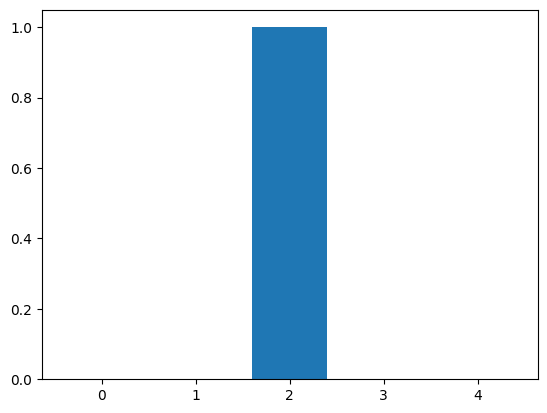

In [336]:
plt.bar(range(len(test_probs_2x[3])), test_probs_2x[0])

<BarContainer object of 43 artists>

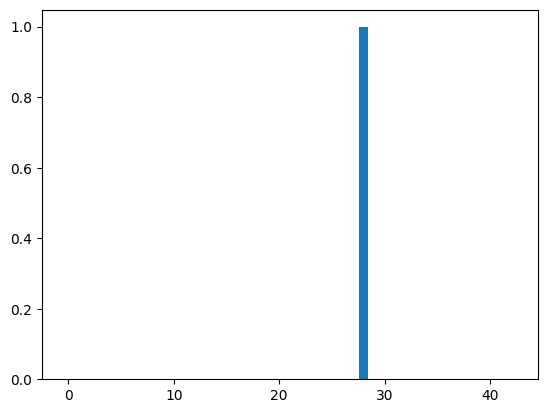

In [338]:
plt.bar(range(len(test_decade_probs_2x[0][0])), test_decade_probs_2x[0][0])

In [383]:
# New
test_preds_2x = []
test_intervals_2x = []
test_true_2x = []
test_probs_2x = []
test_decade_preds_2x = []
test_decade_probs_2x = []
test_decade_true_2x = []

            
with torch.no_grad():
        for batch in tqdm(test_2x_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            century_logits, decade_logits = model_merged(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask']
            )
            
            # Century predictions
            century_predictions = torch.argmax(century_logits, dim=1)
            century_labels = batch['century_labels']
            probabilities = torch.softmax(century_logits, dim=1)
            # Decade predictions
            decade_probabilities = torch.softmax(decade_logits, dim=1)
            decade_predictions = torch.argmax(decade_logits, dim=1)
            decade_labels = batch['decade_labels']
            #print(decade_logits)
            for i, prob in enumerate(probabilities): # Iterate on the batch
                pred = century_predictions[i].item()
                true_label = century_labels[i].item()          

                prediction_set = []
                for label in range(5):
                    nonconformity = 1 - prob[label].item()
                    if nonconformity <= class_thresholds_2x[label]:
                        prediction_set.append(label)

                test_preds_2x.append(pred)
                test_intervals_2x.append(prediction_set)
                test_true_2x.append(true_label)
                test_probs_2x.append(prob.detach().cpu().numpy())
                test_decade_true_2x.append(decade_labels[i].item())
                test_decade_probs_2x.append(decade_probabilities.detach().cpu().numpy())
            test_decade_preds_2x.extend(decade_predictions.detach().cpu().numpy())
            #break
            
            
            #century_true.extend(century_labels.cpu().numpy())
            #century_preds.extend(century_predictions.cpu().numpy())
            

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1513/1513 [17:11<00:00,  1.47it/s]


In [386]:
test_preds_argmax_2x = []       # Traditional argmax (most probable class)
test_preds_argmax_int_2x = []   # Argmax restricted to the prediction set
test_preds_margin_2x = []       # Max margin from threshold in prediction set
test_preds_rel_margin_2x = []   # Max relative margin from threshold in prediction set
test_true_var_2x = []
test_decas_2x = []
test_decas_true_2x = []

for idx, tidx in enumerate(X_test_21b):
    tidx = int(tidx.replace('valid_text', '').replace('.txt', ''))
    
    # if tidx in blacklist_valid:
    #    continue
    intervals = test_intervals_2x[idx]  # Classes in the prediction set
    true_label = test_true_2x[idx]
    probs = test_probs_2x[idx]
    
    # Standard argmax prediction (baseline)
    argmax_pred = np.argmax(probs)
    test_preds_argmax_2x.append(argmax_pred)
    
    # If prediction set is empty use argmax
    if len(intervals) == 0:
        test_preds_argmax_int_2x.append(argmax_pred)
        test_preds_margin_2x.append(argmax_pred)
        test_preds_rel_margin_2x.append(argmax_pred)
        test_true_var_2x.append(true_label)
        continue
    
    # Argmax restricted to prediction set
    interval_probs = {label: probs[label] for label in intervals}
    argmax_int_pred = max(interval_probs, key=interval_probs.get)
    test_preds_argmax_int_2x.append(argmax_int_pred)
    
    # Maximum margin from threshold
    margins = {}
    rel_margins = {}
    for label in intervals:
        nonconformity = 1 - probs[label]
        margin = class_thresholds_2x[label] - nonconformity  # How far below threshold
        margins[label] = margin
        # Relative margin (normalized by threshold)
        rel_margin = margin / class_thresholds_2x[label] if class_thresholds_2x[label] > 0 else 0
        rel_margins[label] = rel_margin
    
    margin_pred = max(margins, key=margins.get)
    rel_margin_pred = max(rel_margins, key=rel_margins.get)
    
    deca = test_decade_preds_2x[idx] % 10
    test_decas_2x.append(deca)
    
    test_decas_true_2x.append(test_decade_true_2x[idx]%10)
    
    test_preds_margin_2x.append(margin_pred)
    test_preds_rel_margin_2x.append(rel_margin_pred)
    test_true_var_2x.append(true_label)
    
    if deca == 9:
        print(argmax_pred, deca)
        print(true_label, test_decade_true_2x[idx]%10)
        break


print(f"argmax (MAE): {mean_avg_error(np.array(test_true_var_2x), np.array(test_preds_argmax_2x))}")
final_rank = mean_avg_error(np.array([ a*10 + b for a, b in zip(test_true_var_2x,test_decas_true_2x)]), np.array([ a*10 + b for a, b in zip(test_preds_argmax_2x,test_decas_2x)]))
print(final_rank)
print(f"argmax restricted to prediction set (MAE): {mean_avg_error(np.array(test_true_var_2x), np.array(test_preds_argmax_int_2x))}")
final_rank = mean_avg_error(np.array([ a*10 + b for a, b in zip(test_true_var_2x,test_decas_true_2x)]), np.array([ a*10 + b for a, b in zip(test_preds_argmax_int_2x,test_decas_2x)]))
print(final_rank)
print(f"max margin (MAE): {mean_avg_error(np.array(test_true_var_2x), np.array(test_preds_margin_2x))}")
final_rank = mean_avg_error(np.array([ a*10 + b for a, b in zip(test_true_var_2x,test_decas_true_2x)]), np.array([ a*10 + b for a, b in zip(test_preds_margin_2x,test_decas_2x)]))
print(final_rank)
print(f"max relative margin (MAE): {mean_avg_error(np.array(test_true_var_2x), np.array(test_preds_rel_margin_2x))}")
final_rank = mean_avg_error(np.array([ a*10 + b for a, b in zip(test_true_var_2x,test_decas_true_2x)]), np.array([ a*10 + b for a, b in zip(test_preds_rel_margin_2x,test_decas_2x)]))
print(final_rank)

# Calculate prediction set size statistics
set_sizes = [len(intervals) for intervals in test_intervals_2x]
avg_set_size = np.mean(set_sizes)
coverage = np.mean([true_label in intervals for true_label, intervals in zip(test_true_2x, test_intervals_2x)])

print("----"*33)
print(f"Average prediction set size: {avg_set_size:.2f}")
print(f"Empirical coverage: {coverage:.4f} (target: {confidence_level:.4f})")

2 9
2 0
argmax (MAE): 0.0
4.833333333333333
argmax restricted to prediction set (MAE): 0.0
4.833333333333333
max margin (MAE): 0.0
4.833333333333333
max relative margin (MAE): 0.0
4.833333333333333
------------------------------------------------------------------------------------------------------------------------------------
Average prediction set size: 2.67
Empirical coverage: 0.9820 (target: 0.9000)


In [ ]:
argmax (MAE): 0.01681818181818182
6.430123966942149
argmax restricted to prediction set (MAE): 0.028140495867768595
6.55904958677686
max margin (MAE): 0.03235537190082645
6.59698347107438
max relative margin (MAE): 0.02871900826446281
6.562851239669421
------------------------------------------------------------------------------------------------------------------------------------
Average prediction set size: 2.67
Empirical coverage: 0.9820 (target: 0.9000)



In [339]:
class MultiTaskLongformerModel(nn.Module):
    def __init__(self):
        super(MultiTaskLongformerModel, self).__init__()
        
        self.longformer = LongformerModel.from_pretrained('allenai/longformer-base-4096')
        
        # Century head (classification)
        self.century_classifier = nn.Sequential(
            nn.Linear(self.longformer.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 5)
        )
        
        # Decade head (regression) - modified to output values between 0 and 49
        self.decade_regressor = nn.Sequential(
            nn.Linear(self.longformer.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()  # Constrains output between 0 and 1
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.longformer(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        
        pooled_output = outputs.last_hidden_state[:, 0, :]
        
        century_logits = self.century_classifier(pooled_output)
        decade_prediction = self.decade_regressor(pooled_output).squeeze(-1) * 42
        
        return century_logits, decade_prediction

In [341]:
regressor = MultiTaskLongformerModel()
regressor.load_state_dict(torch.load('models/task2x/best_model_epoch_6_regression.pt', map_location=device))
regressor.to(device)
print()

In [342]:
# New
test_preds_2x = []
test_intervals_2x = []
test_true_2x = []
test_probs_2x = []
test_decade_preds_2x = []
test_decade_probs_2x = []
test_decade_true_2x = []

            
with torch.no_grad():
        for batch in tqdm(test_2x_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            century_logits, decade_logits = regressor(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask']
            )
            
            # Century predictions
            century_predictions = torch.argmax(century_logits, dim=1)
            century_labels = batch['century_labels']
            probabilities = torch.softmax(century_logits, dim=1)
            # Decade predictions
            print(decade_logits)
            break
            decade_probabilities = torch.softmax(decade_logits, dim=1)
            decade_predictions = torch.argmax(decade_logits, dim=1)
            decade_labels = batch['decade_labels']
            print(decade_logits)
            for i, prob in enumerate(probabilities): # Iterate on the batch
                pred = century_predictions[i].item()
                true_label = century_labels[i].item()          

                prediction_set = []
                for label in range(5):
                    nonconformity = 1 - prob[label].item()
                    if nonconformity <= class_thresholds_2x[label]:
                        prediction_set.append(label)

                test_preds_2x.append(pred)
                test_intervals_2x.append(prediction_set)
                test_true_2x.append(true_label)
                test_probs_2x.append(prob.detach().cpu().numpy())
                test_decade_true_2x.append(decade_labels[i].item())
                test_decade_probs_2x.append(decade_probabilities.detach().cpu().numpy())
            test_decade_preds_2x.extend(decade_predictions.detach().cpu().numpy())
            break
            
            
            #century_true.extend(century_labels.cpu().numpy())
            #century_preds.extend(century_predictions.cpu().numpy())
            

  0%|                                                                                                                                                                                        | 0/1513 [00:00<?, ?it/s]

tensor([28.0673, 20.5699, 25.8489, 40.5376, 26.3762, 28.9495, 26.0579, 28.9641,
        26.5412, 24.8539, 24.6859, 28.1546, 28.4936, 27.4894, 28.6315, 29.2122],
       device='cuda:0')


## Consistent

In [388]:
class ConsistentMultiTaskLongformerModel(nn.Module):
    def __init__(self):
        super(ConsistentMultiTaskLongformerModel, self).__init__()
        
        self.longformer = LongformerModel.from_pretrained('allenai/longformer-base-4096')
        
        # Shared intermediate layer
        self.shared_layer = nn.Sequential(
            nn.Linear(self.longformer.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Century head
        self.century_classifier = nn.Linear(512, 5)
        
        # Decade head
        self.decade_classifier = nn.Linear(512, 10)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.longformer(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        
        pooled_output = outputs.last_hidden_state[:, 0, :]
        shared_features = self.shared_layer(pooled_output)
        
        century_logits = self.century_classifier(shared_features)
        decade_logits = self.decade_classifier(shared_features)
        
        return century_logits, decade_logits

In [406]:
consistent = ConsistentMultiTaskLongformerModel()
consistent.load_state_dict(torch.load('models/task2x_consistent/best_model_epoch_3__consistent.pt', map_location=device))
consistent.to(device)
print()

In [407]:
# Calibration
calib_2xc_probs = []
calib_2xc_preds = []
calib_2xc_true = []

model_merged.eval()

with torch.no_grad():
    for batch in tqdm(calib_2x_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        century_logits, decade_logits = consistent(
            input_ids=batch['input_ids'], 
            attention_mask=batch['attention_mask']
        )

        # Century predictions
        century_predictions = torch.argmax(century_logits, dim=1)
        century_labels = batch['century_labels']

        # Decade predictions
        #decade_predictions = torch.argmax(decade_logits, dim=1)
        #decade_labels = batch['decade_labels']

        calib_2xc_true.extend(century_labels.cpu().numpy())
        calib_2xc_preds.extend(century_predictions.cpu().numpy())
        calib_2xc_probs.extend(probabilities.detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1513/1513 [15:50<00:00,  1.59it/s]


In [408]:
class_nonconformity_2xc = {class_idx: [] for class_idx in range(5)}

for i, (prob, true_label) in enumerate(zip(calib_2xc_probs, calib_2xc_true)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_2xc[true_label].append(nonconformity)

class_thresholds_2xc = {}
confidence_level = 0.90
alpha = 1 - confidence_level

for class_idx, scores in class_nonconformity_2xc.items():
    n_class_samples = len(scores)  # Use class-specific count
    q = np.ceil((n_class_samples + 1) * (1 - alpha)) / n_class_samples
    #q = min(1, np.ceil((n_class_samples + 1) * (1 - alpha)) / n_class_samples)
    class_thresholds_2xc[class_idx] = np.quantile(scores, (1 - alpha))

In [433]:
# New
test_preds_2xc = []
test_intervals_2xc = []
test_true_2xc = []
test_probs_2xc = []
test_decade_preds_2xc = []
test_decade_probs_2xc = []
test_decade_true_2xc = []

            
with torch.no_grad():
        for batch in tqdm(test_2x_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            century_logits, decade_logits = consistent(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask']
            )
            
            # Century predictions
            century_predictions = torch.argmax(century_logits, dim=1)
            century_labels = batch['century_labels']
            probabilities = torch.softmax(century_logits, dim=1)
            # Decade predictions
            decade_probabilities = torch.softmax(decade_logits, dim=1)
            decade_predictions = torch.argmax(decade_logits, dim=1)
            decade_labels = batch['decade_labels']
            #print(decade_logits)
            for i, prob in enumerate(probabilities): # Iterate on the batch
                pred = century_predictions[i].item()
                true_label = century_labels[i].item()          

                prediction_set = []
                for label in range(5):
                    nonconformity = 1 - prob[label].item()
                    if nonconformity <= class_thresholds_2xc[label]:
                        prediction_set.append(label)

                test_preds_2xc.append(pred)
                test_intervals_2xc.append(prediction_set)
                test_true_2xc.append(true_label)
                test_probs_2xc.append(prob.detach().cpu().numpy())
                test_decade_true_2xc.append(decade_labels[i].item())
                test_decade_probs_2xc.append(decade_probabilities[i].detach().cpu().numpy())

            test_decade_preds_2xc.extend(decade_predictions.detach().cpu().numpy())
            #break
            
            
            #century_true.extend(century_labels.cpu().numpy())
            #century_preds.extend(century_predictions.cpu().numpy())
            

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1513/1513 [15:58<00:00,  1.58it/s]


Pred: 2 8
True: 2 0
[2]


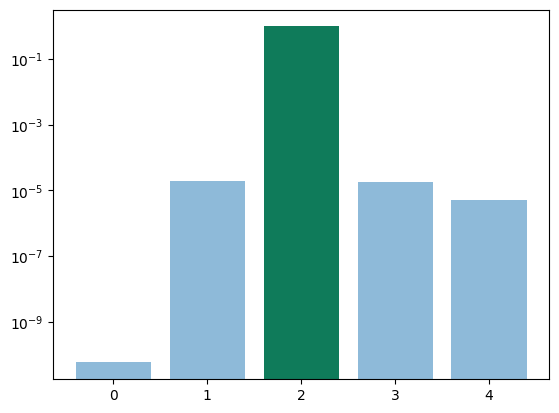

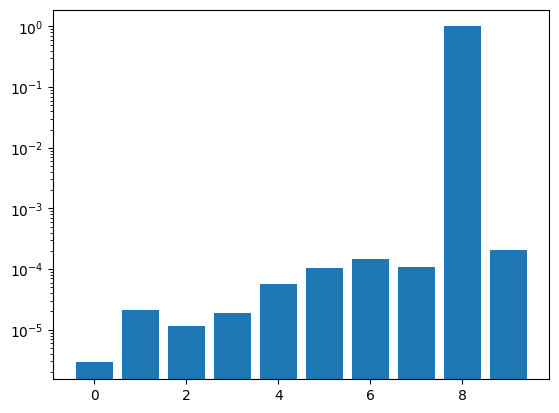

Pred: 2 9
True: 2 0
[1, 2]


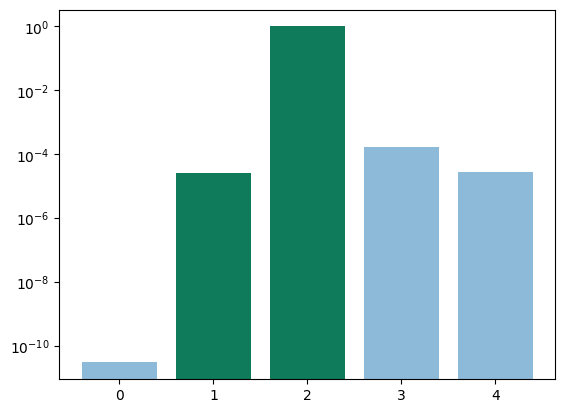

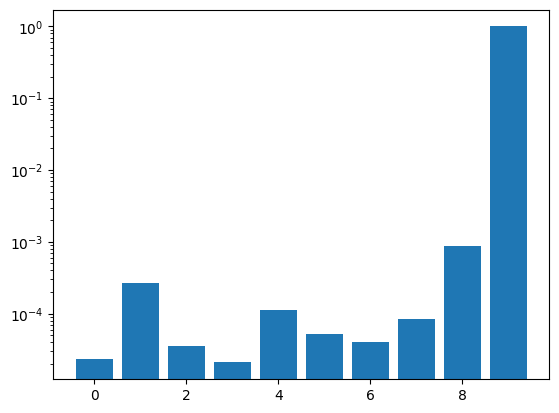

Pred: 2 8
True: 2 0
[0, 1, 2, 3, 4]


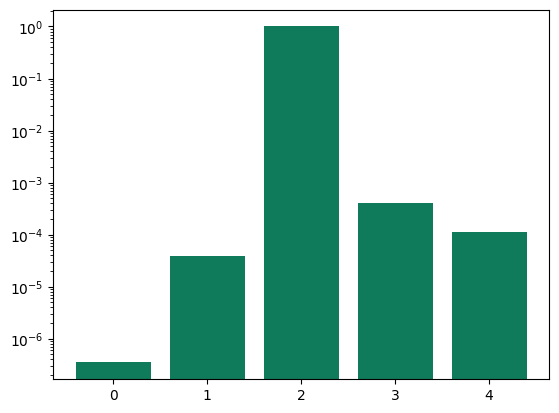

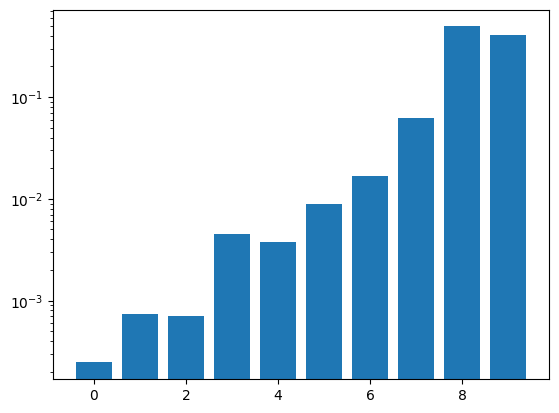

Pred: 2 8
True: 2 0
[2]


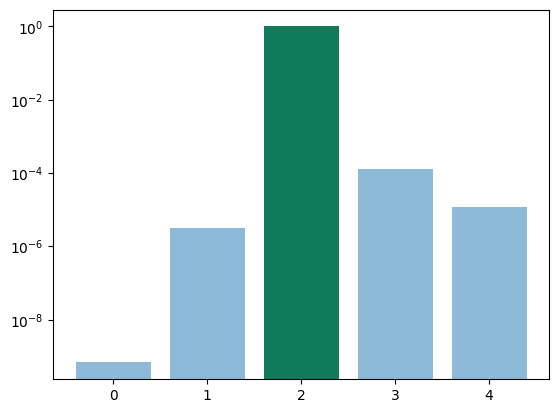

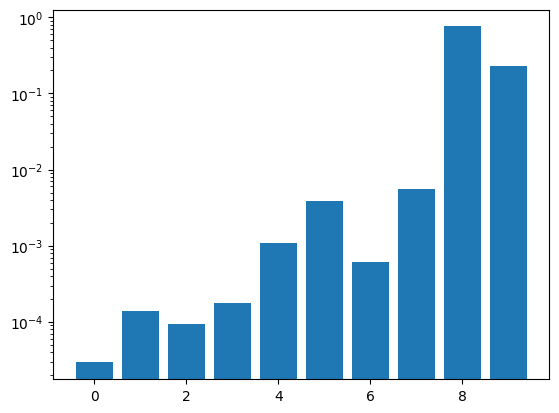

Pred: 2 8
True: 2 0
[2, 3]


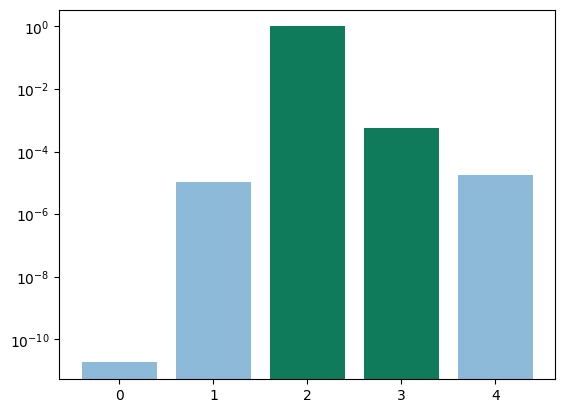

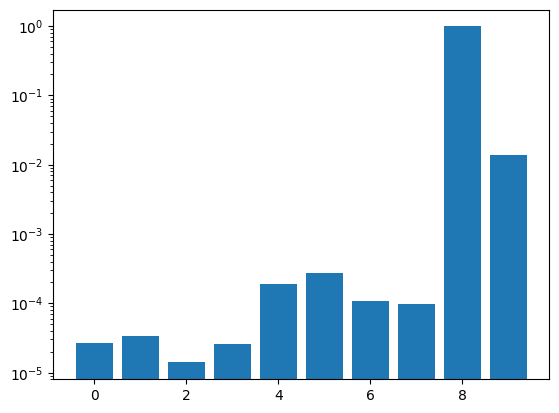

Pred: 2 8
True: 2 0
[2, 3]


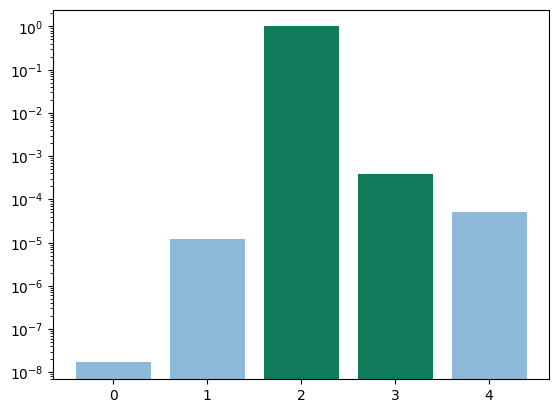

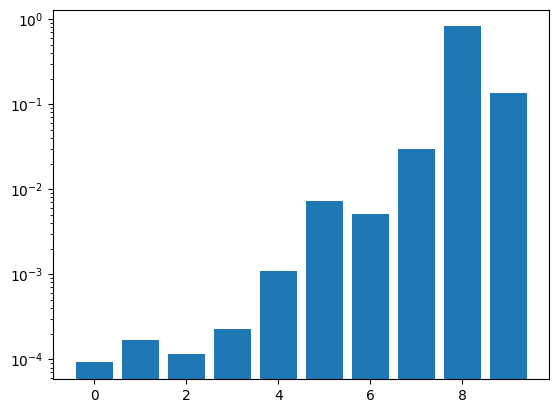

Pred: 2 9
True: 2 0
[2]


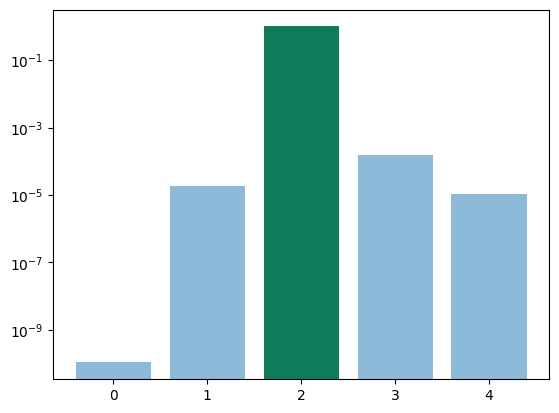

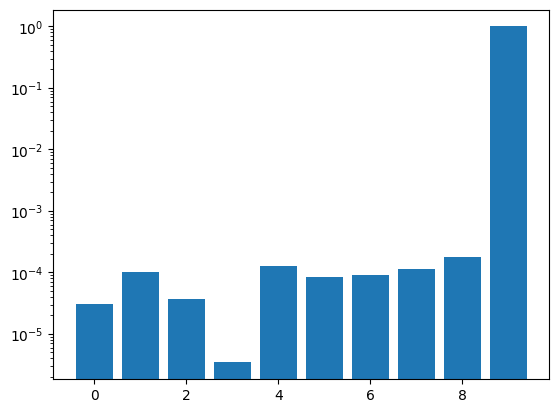

Pred: 2 9
True: 2 0
[2]


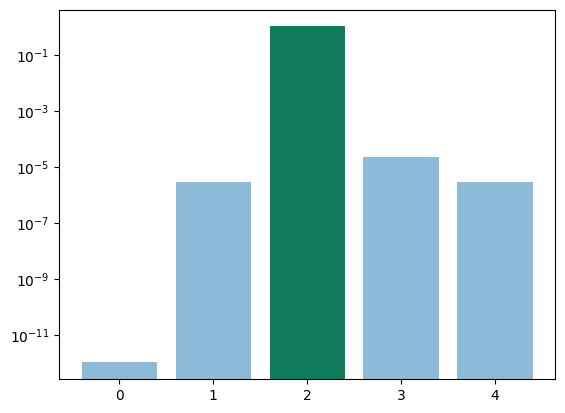

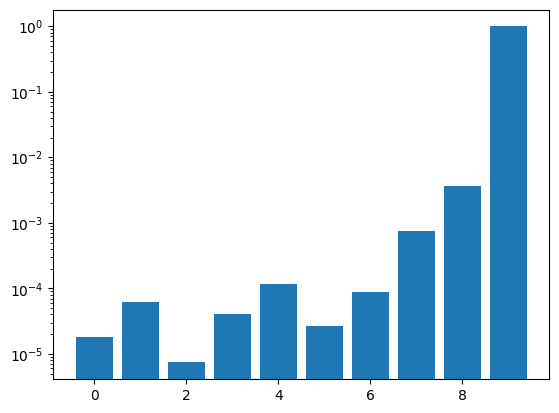

Pred: 2 8
True: 2 0
[1, 2, 3]


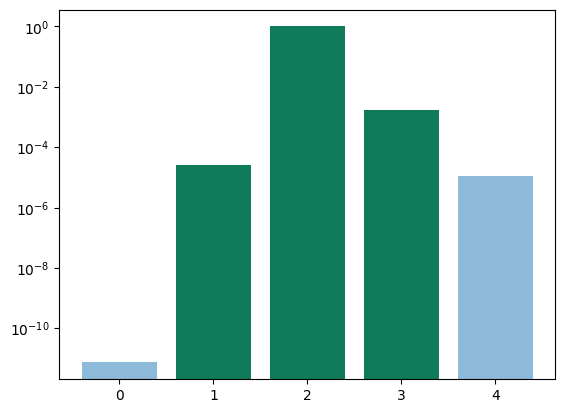

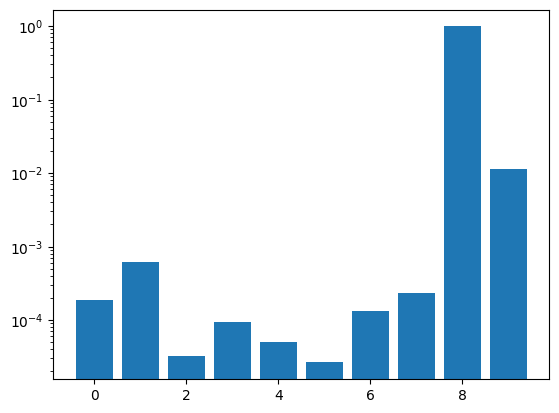

Pred: 2 9
True: 2 0
[1, 2, 3]


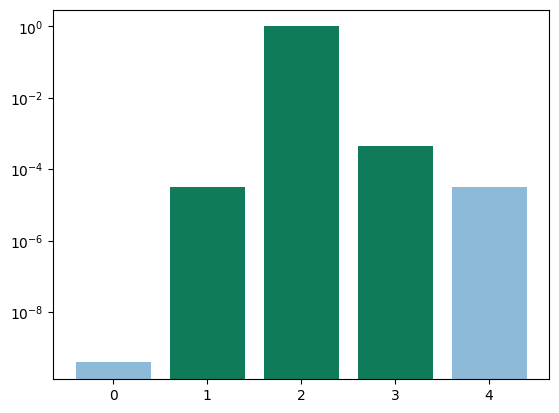

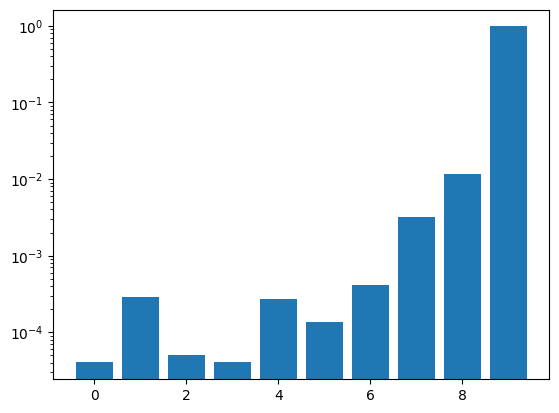

argmax (MAE): 0.0
6.173913043478261
argmax restricted to prediction set (MAE): 0.0
6.173913043478261
max margin (MAE): 0.0
6.173913043478261
max relative margin (MAE): 0.0
6.173913043478261
------------------------------------------------------------------------------------------------------------------------------------
Average prediction set size: 2.67
Empirical coverage: 0.9820 (target: 0.9000)


In [442]:
test_preds_argmax_2xc = []       # Traditional argmax (most probable class)
test_preds_argmax_int_2xc = []   # Argmax restricted to the prediction set
test_preds_margin_2xc = []       # Max margin from threshold in prediction set
test_preds_rel_margin_2xc = []   # Max relative margin from threshold in prediction set
test_true_var_2xc = []
test_decas_2xc = []
test_decas_true_2xc = []

i = 0
for idx, tidx in enumerate(X_test_21b):
    tidx = int(tidx.replace('valid_text', '').replace('.txt', ''))
    
    # if tidx in blacklist_valid:
    #    continue
    intervals = test_intervals_2xc[idx]  # Classes in the prediction set
    true_label = test_true_2xc[idx]
    probs = test_probs_2xc[idx]
    
    # Standard argmax prediction (baseline)
    argmax_pred = np.argmax(probs)
    test_preds_argmax_2xc.append(argmax_pred)
    
    # If prediction set is empty use argmax
    if len(intervals) == 0:
        test_preds_argmax_int_2xc.append(argmax_pred)
        test_preds_margin_2xc.append(argmax_pred)
        test_preds_rel_margin_2xc.append(argmax_pred)
        test_true_var_2xc.append(true_label)
        continue
    
    # Argmax restricted to prediction set
    interval_probs = {label: probs[label] for label in intervals}
    argmax_int_pred = max(interval_probs, key=interval_probs.get)
    test_preds_argmax_int_2xc.append(argmax_int_pred)
    
    # Maximum margin from threshold
    margins = {}
    rel_margins = {}
    for label in intervals:
        nonconformity = 1 - probs[label]
        margin = class_thresholds_2xc[label] - nonconformity  # How far below threshold
        margins[label] = margin
        # Relative margin (normalized by threshold)
        rel_margin = margin / class_thresholds_2xc[label] if class_thresholds_2xc[label] > 0 else 0
        rel_margins[label] = rel_margin
    
    margin_pred = max(margins, key=margins.get)
    rel_margin_pred = max(rel_margins, key=rel_margins.get)
    
    test_decas_2xc.append(test_decade_preds_2xc[idx])
    
    test_decas_true_2xc.append(test_decade_true_2x[idx])
    
    test_preds_margin_2xc.append(margin_pred)
    test_preds_rel_margin_2xc.append(rel_margin_pred)
    test_true_var_2xc.append(true_label)
    
    deca = np.argmax(test_decade_probs_2xc[idx])
    if deca in [8,9]:
        print("Pred:", argmax_pred, deca)
        print("True:", true_label, test_decade_true_2xc[idx]%10)
        # print(test_probs_2xc[idx])
        # print(test_decade_probs_2xc[idx])
        print(test_intervals_2xc[idx])
        plt.bar(class_thresholds_2xc.keys(), [ test_probs_2xc[idx][ind] if  test_probs_2xc[idx][ind] >= 1 - x else 0 for ind, x in enumerate(class_thresholds_2xc.values())], color='green', alpha=1, label='threshold')
        
        plt.bar(range(5), test_probs_2xc[idx], alpha=0.5)
        plt.yscale('log')
        plt.show()
        plt.bar(range(10), test_decade_probs_2xc[idx])
        plt.yscale('log')
        plt.show()
        i += 1
        if i == 10:
            break


print(f"argmax (MAE): {mean_avg_error(np.array(test_true_var_2xc), np.array(test_preds_argmax_2xc))}")
final_rank = mean_avg_error(np.array([ a*10 + b for a, b in zip(test_true_var_2xc,test_decas_true_2xc)]), np.array([ a*10 + b for a, b in zip(test_preds_argmax_2xc,test_decas_2xc)]))
print(final_rank)
print(f"argmax restricted to prediction set (MAE): {mean_avg_error(np.array(test_true_var_2xc), np.array(test_preds_argmax_int_2xc))}")
final_rank = mean_avg_error(np.array([ a*10 + b for a, b in zip(test_true_var_2xc,test_decas_true_2xc)]), np.array([ a*10 + b for a, b in zip(test_preds_argmax_int_2xc,test_decas_2xc)]))
print(final_rank)
print(f"max margin (MAE): {mean_avg_error(np.array(test_true_var_2xc), np.array(test_preds_margin_2xc))}")
final_rank = mean_avg_error(np.array([ a*10 + b for a, b in zip(test_true_var_2xc,test_decas_true_2xc)]), np.array([ a*10 + b for a, b in zip(test_preds_margin_2xc,test_decas_2xc)]))
print(final_rank)
print(f"max relative margin (MAE): {mean_avg_error(np.array(test_true_var_2xc), np.array(test_preds_rel_margin_2xc))}")
final_rank = mean_avg_error(np.array([ a*10 + b for a, b in zip(test_true_var_2xc,test_decas_true_2xc)]), np.array([ a*10 + b for a, b in zip(test_preds_rel_margin_2xc,test_decas_2xc)]))
print(final_rank)

# Calculate prediction set size statistics
set_sizes = [len(intervals) for intervals in test_intervals_2x]
avg_set_size = np.mean(set_sizes)
coverage = np.mean([true_label in intervals for true_label, intervals in zip(test_true_2x, test_intervals_2x)])

print("----"*33)
print(f"Average prediction set size: {avg_set_size:.2f}")
print(f"Empirical coverage: {coverage:.4f} (target: {confidence_level:.4f})")

In [404]:
for x in test_2x_dataset:
    print(x)
    break

{'input_ids': tensor([    0, 12186, 18993,  ...,     1,     1,     1]), 'attention_mask': tensor([1, 1, 1,  ..., 0, 0, 0]), 'century_labels': tensor(2), 'decade_labels': tensor(0)}


### MAPIE

In [468]:
from sklearn.base import BaseEstimator, ClassifierMixin

class LongformerModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, task="century", device="cuda", batch_size=8):
        """
        Wrapper for the ConsistentMultiTaskLongformerModel to make it compatible with MAPIE.
        
        Args:
            model: The PyTorch model
            task: Which task to wrap, either "century" or "decade"
            device: The device to run the model on
            batch_size: Batch size for processing predictions in batches
        """
        self.model = model
        self.task = task
        self.device = device
        self.batch_size = batch_size
        self.model.to(device)
        self.model.eval()
        
        # Initialize scikit-learn required attributes
        # We'll set proper values during fit
        self.classes_ = None
        self.n_features_in_ = None
        self.is_fitted_ = False
        
    def fit(self, X, y):
        """
        Prepare the wrapper for prediction.
        X is expected to be a list of indices that reference the actual data.
        """
        # Set the number of features to match the input structure
        # For our wrapper, X is just a list of indices, so n_features_in_ = 1
        self.n_features_in_ = 1
        
        # Set classes based on unique values in y
        self.classes_ = np.unique(y)
        
        # Mark as fitted
        self.is_fitted_ = True
        
        return self
    
    def predict(self, X, data_storage=None):
        """
        Make predictions using the wrapped model.
        X is expected to be a list of indices that reference the actual data in data_storage.
        """
        if not self.is_fitted_:
            raise ValueError("This model is not fitted yet. Call 'fit' first.")
        
        self.model.eval()
        predictions = []
        
        # Create batches of indices
        # Flatten X if it's 2D since we only need 1D indices
        if X.ndim > 1:
            X_flat = X.flatten()
        else:
            X_flat = X
            
        batch_indices = [X_flat[i:i+self.batch_size] for i in range(0, len(X_flat), self.batch_size)]
        
        for batch_idx in tqdm(batch_indices, desc=f"Predicting {self.task} classes"):
            batch_preds = []
            
            with torch.no_grad():
                for idx in batch_idx:
                    # Convert index to integer scalar if it's not already
                    idx = int(idx)
                    
                    # Get actual input data from storage
                    input_ids, attention_mask = data_storage[idx]
                    
                    input_ids = input_ids.to(self.device)
                    attention_mask = attention_mask.to(self.device)
                    
                    century_logits, decade_logits = self.model(input_ids, attention_mask)
                    
                    if self.task == "century":
                        logits = century_logits
                    else:
                        logits = decade_logits
                    
                    pred = torch.argmax(logits, dim=1).cpu().numpy()[0]
                    batch_preds.append(pred)
            
            predictions.extend(batch_preds)
        
        return np.array(predictions)
    
    def predict_proba(self, X, data_storage=None):
        """
        Predict class probabilities.
        X is expected to be a list of indices that reference the actual data in data_storage.
        """
        if not self.is_fitted_:
            raise ValueError("This model is not fitted yet. Call 'fit' first.")
        
        self.model.eval()
        probabilities = []
        
        # Create batches of indices
        # Flatten X if it's 2D since we only need 1D indices
        if X.ndim > 1:
            X_flat = X.flatten()
        else:
            X_flat = X
            
        batch_indices = [X_flat[i:i+self.batch_size] for i in range(0, len(X_flat), self.batch_size)]
        
        for batch_idx in tqdm(batch_indices, desc=f"Computing {self.task} probabilities"):
            batch_probs = []
            
            with torch.no_grad():
                for idx in batch_idx:
                    # Convert index to integer scalar if it's not already
                    idx = int(idx)
                    
                    # Get actual input data from storage
                    input_ids, attention_mask = data_storage[idx]
                    
                    input_ids = input_ids.to(self.device)
                    attention_mask = attention_mask.to(self.device)
                    
                    century_logits, decade_logits = self.model(input_ids, attention_mask)
                    
                    if self.task == "century":
                        logits = century_logits
                    else:
                        logits = decade_logits
                    
                    probs = torch.softmax(logits, dim=1).cpu().numpy()
                    batch_probs.append(probs)
            
            probabilities.extend(batch_probs)
        
        return np.vstack(probabilities)

In [465]:
def prepare_data_for_mapie(dataloader, device="cuda", desc="Preparing data"):
    """
    Convert a PyTorch DataLoader to a format suitable for MAPIE with progress bar.
    
    Returns:
        data_storage: List of (input_ids, attention_mask) tuples
        X_indices: Simple array of indices for MAPIE
        y_century: Century labels
        y_decade: Decade labels
    """
    data_storage = []  # Actual data storage
    y_century = []
    y_decade = []
    
    # Add progress bar
    progress_bar = tqdm(dataloader, desc=desc)
    
    for batch in progress_bar:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        century_labels = batch['century_labels'].cpu().numpy()
        decade_labels = batch['decade_labels'].cpu().numpy()
        
        # Add each example to our lists
        for i in range(input_ids.shape[0]):
            data_storage.append((input_ids[i:i+1], attention_mask[i:i+1]))
            y_century.append(century_labels[i])
            y_decade.append(decade_labels[i])
    
    # Create simple indices for MAPIE (this will satisfy scikit-learn's shape requirements)
    X_indices = np.arange(len(data_storage)).reshape(-1, 1)
    
    return data_storage, X_indices, np.array(y_century), np.array(y_decade)

In [466]:
from mapie.classification import MapieClassifier
import functools

def run_conformal_prediction(model, calib_dataloader, test_dataloader, device="cuda", batch_size=8):
    print("Starting conformal prediction process...")
    
    # Prepare calibration and test data with progress bars
    print("\nPreparing data:")
    calib_data_storage, X_calib, y_calib_century, y_calib_decade = prepare_data_for_mapie(
        calib_dataloader, device, desc="Preparing calibration data"
    )
    test_data_storage, X_test, y_test_century, y_test_decade = prepare_data_for_mapie(
        test_dataloader, device, desc="Preparing test data"
    )
    
    # Create model wrappers for each task
    print("\nInitializing model wrappers:")
    century_model = LongformerModelWrapper(model, task="century", device=device, batch_size=batch_size)
    decade_model = LongformerModelWrapper(model, task="decade", device=device, batch_size=batch_size)
    
    # First manually fit the model wrappers to ensure they're marked as fitted
    print("\nFitting century model wrapper...")
    century_model.fit(X_calib, y_calib_century)
    
    print("Fitting decade model wrapper...")
    decade_model.fit(X_calib, y_calib_decade)
    
    # Create partial functions with data storage
    century_predict = functools.partial(century_model.predict, data_storage=calib_data_storage)
    century_predict_proba = functools.partial(century_model.predict_proba, data_storage=calib_data_storage)
    
    decade_predict = functools.partial(decade_model.predict, data_storage=calib_data_storage)
    decade_predict_proba = functools.partial(decade_model.predict_proba, data_storage=calib_data_storage)
    
    # Override methods to include data storage
    century_model.predict = century_predict
    century_model.predict_proba = century_predict_proba
    
    decade_model.predict = decade_predict
    decade_model.predict_proba = decade_predict_proba
    
    # Set up MAPIE for century prediction
    print("\nSetting up MAPIE for century classification...")
    mapie_century = MapieClassifier(
        estimator=century_model,
        method="score",
        cv="prefit"
    )
    
    # Set up MAPIE for decade prediction
    print("Setting up MAPIE for decade classification...")
    mapie_decade = MapieClassifier(
        estimator=decade_model,
        method="score",
        cv="prefit"
    )
    
    # Calibrate the MAPIE models
    print("\nCalibrating century model with MAPIE...")
    mapie_century.fit(X_calib, y_calib_century)
    
    print("Calibrating decade model with MAPIE...")
    mapie_decade.fit(X_calib, y_calib_decade)
    
    # Update predict functions for test data
    century_test_predict = functools.partial(century_model.predict, data_storage=test_data_storage)
    century_test_predict_proba = functools.partial(century_model.predict_proba, data_storage=test_data_storage)
    
    decade_test_predict = functools.partial(decade_model.predict, data_storage=test_data_storage)
    decade_test_predict_proba = functools.partial(decade_model.predict_proba, data_storage=test_data_storage)
    
    century_model.predict = century_test_predict
    century_model.predict_proba = century_test_predict_proba
    
    decade_model.predict = decade_test_predict
    decade_model.predict_proba = decade_test_predict_proba
    
    # Define confidence levels
    alpha = [0.05, 0.1, 0.2]  # 95%, 90%, and 80% confidence levels
    
    # Make predictions with confidence sets
    print("\nGenerating predictions with confidence sets for century...")
    y_pred_century, y_ps_century = mapie_century.predict(X_test, alpha=alpha)
    
    print("Generating predictions with confidence sets for decade...")
    y_pred_decade, y_ps_decade = mapie_decade.predict(X_test, alpha=alpha)
    
    # Calculate coverage and set sizes
    print("\nCalculating metrics...")
    results = {}
    
    for i, a in enumerate(alpha):
        conf_level = 1 - a
        
        # Calculate metrics for century predictions
        century_coverage = calculate_coverage(y_test_century, y_ps_century[:, :, i])
        century_set_size = calculate_avg_set_size(y_ps_century[:, :, i])
        
        # Calculate metrics for decade predictions
        decade_coverage = calculate_coverage(y_test_decade, y_ps_decade[:, :, i])
        decade_set_size = calculate_avg_set_size(y_ps_decade[:, :, i])
        
        results[f"{int(conf_level*100)}%"] = {
            'century': {
                'coverage': century_coverage,
                'avg_set_size': century_set_size
            },
            'decade': {
                'coverage': decade_coverage,
                'avg_set_size': decade_set_size
            }
        }
    
    print("\nConformal prediction process completed!")
    
    return {
        'results': results,
        'predictions': {
            'century': {
                'point_predictions': y_pred_century,
                'prediction_sets': y_ps_century
            },
            'decade': {
                'point_predictions': y_pred_decade,
                'prediction_sets': y_ps_decade
            }
        },
        'alpha': alpha
    }

def calculate_coverage(y_true, y_pred_sets):
    """Calculate empirical coverage of prediction sets"""
    coverage = np.mean([y_true[i] in y_pred_sets[i] for i in range(len(y_true))])
    return coverage

def calculate_avg_set_size(y_pred_sets):
    """Calculate average size of prediction sets"""
    set_sizes = np.sum(y_pred_sets != -1, axis=1)
    return np.mean(set_sizes)

In [469]:
import time


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run conformal prediction with progress tracking
print(f"Starting conformal prediction on {device}...")
start_time = time.time()

conformal_results = run_conformal_prediction(
    model=consistent,
    calib_dataloader=calib_2x_dataloader,
    test_dataloader=test_2x_dataloader,
    device=device,
    batch_size=8  # Adjust based on your GPU memory
)

elapsed_time = time.time() - start_time
print(f"Total time elapsed: {elapsed_time:.2f} seconds")

# Print results
for conf_level, metrics in conformal_results['results'].items():
    print(f"\nConfidence level: {conf_level}")
    print(f"  Century task: coverage={metrics['century']['coverage']:.4f}, avg set size={metrics['century']['avg_set_size']:.2f}")
    print(f"  Decade task: coverage={metrics['decade']['coverage']:.4f}, avg set size={metrics['decade']['avg_set_size']:.2f}")

Starting conformal prediction on cuda...
Starting conformal prediction process...

Preparing data:


Preparing test data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1513/1513 [02:29<00:00, 10.11it/s]



Initializing model wrappers:

Fitting century model wrapper...
Fitting decade model wrapper...

Setting up MAPIE for century classification...
Setting up MAPIE for decade classification...

Calibrating century model with MAPIE...


Computing century probabilities: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3025/3025 [09:44<00:00,  5.18it/s]


Calibrating decade model with MAPIE...


Computing decade probabilities: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3025/3025 [09:49<00:00,  5.13it/s]



Generating predictions with confidence sets for century...


Computing century probabilities: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3025/3025 [10:03<00:00,  5.01it/s]


Generating predictions with confidence sets for decade...


Computing decade probabilities: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3025/3025 [09:56<00:00,  5.07it/s]



Calculating metrics...

Conformal prediction process completed!
Total time elapsed: 3866.83 seconds

Confidence level: 95%
  Century task: coverage=0.0066, avg set size=5.00
  Decade task: coverage=0.0500, avg set size=10.00

Confidence level: 90%
  Century task: coverage=0.0020, avg set size=5.00
  Decade task: coverage=0.1184, avg set size=10.00

Confidence level: 80%
  Century task: coverage=0.0001, avg set size=5.00
  Decade task: coverage=0.2805, avg set size=10.00


In [478]:
np.min(conformal_results['predictions']['century']['point_predictions'])

0

In [489]:
mi = 5
for x in test_2x_dataloader:
    aaa = x['century_labels'].numpy()
    mi = np.min(aaa) if np.min(aaa) < mi else mi

print(mi)

0


In [490]:
class SingleHeadLongformerModel(nn.Module):
    def __init__(self):
        super(SingleHeadLongformerModel, self).__init__()
        
        self.longformer = LongformerModel.from_pretrained('allenai/longformer-base-4096')
        
        # Regression head - outputs a single continuous value
        self.decade_regressor = nn.Sequential(
            nn.Linear(self.longformer.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.longformer(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        
        pooled_output = outputs.last_hidden_state[:, 0, :]
        decade_prediction = self.decade_regressor(pooled_output).squeeze(-1)
        
        return decade_prediction

In [601]:
regressor = SingleHeadLongformerModel()
regressor.load_state_dict(torch.load('models/task2x/best_single_head_regression_model_epoch_4.pt', map_location=device))
regressor.to(device)
print()

In [602]:
def convert_to_absolute_decade(century, decade):
    """Convert century (0-4) and decade (0-9) to absolute decade (0-42)"""
    return century * 10 + decade

class FileBasedSingleTaskDataset(Dataset):
    def __init__(self, file_paths, path, century_labels, decade_labels, tokenizer, max_length=1536):
        self.file_paths = file_paths
        self.path = path
        self.century_labels = century_labels
        self.decade_labels = decade_labels
        self.tokenizer = tokenizer
        self.max_length = max_length            # default 512*3 = 1536
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        century = self.century_labels[idx]
        decade = self.decade_labels[idx]
        
        # Convert to absolute decade label
        absolute_decade = convert_to_absolute_decade(century, decade)
        
        with open(os.path.join(self.path, file_path), 'r', encoding='utf-8') as f:
            text = f.read()
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        encoding['labels'] = torch.tensor(absolute_decade, dtype=torch.long)
        
        return encoding

In [593]:
train21 = pd.read_csv('./data/Task2/task2.1/train.csv')
valid21 = pd.read_csv('./data/Task2/task2.1/valid.csv')

train21.rename(columns={'label': 'century'}, inplace=True)
train21['file_name'] = train21['id']
train21['id'] = train21.id.str.replace('train_text', '').str.replace('.txt', '').astype(int)
train21.set_index('id', inplace=True)

valid21.rename(columns={'label': 'century'}, inplace=True)
valid21['file_name'] = valid21['id']
valid21['id'] = valid21.id.str.replace('valid_text', '').str.replace('.txt', '').astype(int)
valid21.set_index('id', inplace=True)

# Task 2.2
train22 = pd.read_csv('./data/Task2/task2.2/train.csv')
valid22 = pd.read_csv('./data/Task2/task2.2/valid.csv')

train22.rename(columns={'label': 'century'}, inplace=True)
train22['file_name'] = train22['id']
train22['id'] = train22.id.str.replace('train_text', '').str.replace('.txt', '').astype(int)
train22.set_index('id', inplace=True)

valid22.rename(columns={'label': 'century'}, inplace=True)
valid22['file_name'] = valid22['id']
valid22['id'] = valid22.id.str.replace('valid_text', '').str.replace('.txt', '').astype(int)
valid22.set_index('id', inplace=True)

X_train_21 = [] # file names (.txt)
y_train_21 = [] 

X_valid_21 = [] # file names (.txt)
y_valid_21 = []

for idx, row in train21.iterrows():
    file_name = row.file_name
    century = row.century

    with open(os.path.join(train_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower():
        continue

    if idx in blacklist_train:
        continue

    X_train_21.append(file_name)
    y_train_21.append(century-1)

for idx, row in valid21.iterrows():
    file_name = row.file_name
    century = row.century

    with open(os.path.join(valid_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower():
        continue

    if idx in blacklist_valid:
        continue
        
    X_valid_21.append(file_name)
    y_valid_21.append(century-1)

X_train_22 = [] # file names (.txt)
y_train_22 = []

X_valid_22 = [] # file names (.txt)
y_valid_22 = []

for idx, row in train22.iterrows():
    file_name = row.file_name
    century = row.century
    if idx in blacklist_train:
        continue

    with open(os.path.join(train_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower():
        continue

    if idx in blacklist_train:
        continue

    X_train_22.append(file_name)
    y_train_22.append(century-1)

for idx, row in valid22.iterrows():
    file_name = row.file_name
    century = row.century
    if idx in blacklist_valid:
        continue

    with open(os.path.join(valid_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower():
        continue
    
    if idx in blacklist_valid:
        continue

    X_valid_22.append(file_name)
    y_valid_22.append(century-1)

# Double check the order of the data
for x21, x22 in zip(X_train_21, X_train_22):
    assert x21 == x22

for x21, x22 in zip(X_valid_21, X_valid_22):
    assert x21 == x22


In [594]:
indices = np.arange(len(X_valid_21))

# Include indices in the original train_test_split
X_calib_21, X_test_21, y_calib_21, y_test_21, calib_indices, test_indices = train_test_split(
    X_valid_21, y_valid_21, indices, 
    test_size=0.5, random_state=RANDOM_SEED
)

# Now use these same indices to split y_calib_22b
y_calib_22 = np.array(y_valid_22)[calib_indices]
y_test_22 = np.array(y_valid_22)[test_indices]

In [595]:
#valid2x = FileBasedSingleTaskDataset(X_valid_21, valid_path, y_valid_21, y_valid_22, tokenizer)

calib_2x_dataset = FileBasedSingleTaskDataset(X_calib_21, valid_path, y_calib_21, y_calib_22, tokenizer)
test_2x_dataset = FileBasedSingleTaskDataset(X_test_21, valid_path, y_test_21, y_test_22, tokenizer)
               

calib_2x_dataloader = DataLoader(calib_2x_dataset, batch_size=16, shuffle=False)
test_2x_dataloader = DataLoader(test_2x_dataset, batch_size=16, shuffle=False)

In [603]:
def compute_nonconformity_scores(model, dataloader, device='cuda'):
    model.eval()
    nonconformity_scores = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            # Adjust according to your dataloader's output format
            if isinstance(batch, dict):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
            else:  # If your dataloader returns a tuple
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
            
            # Get predictions
            predictions = model(input_ids, attention_mask)
            
            # Calculate absolute residuals as nonconformity scores
            scores = torch.abs(predictions - labels)
            nonconformity_scores.append(scores.cpu())
    
    # Flatten and convert to numpy array
    return torch.cat(nonconformity_scores).numpy()

nonconformity_scores = compute_nonconformity_scores(regressor, calib_2x_dataloader, device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1497/1497 [15:56<00:00,  1.56it/s]


In [597]:
def predict_with_intervals_and_metrics(model, dataloader, nonconformity_scores, alpha=0.1, device='cuda'):
    """
    Make predictions with conformal prediction intervals and calculate evaluation metrics
    
    Args:
        model: Trained model
        dataloader: Test dataloader
        nonconformity_scores: Array of nonconformity scores from calibration set
        alpha: Significance level (e.g., 0.1 for 90% confidence)
        device: Computing device
        
    Returns:
        Dictionary with predictions, intervals, and evaluation metrics
    """
    model.eval()
    all_predictions = []
    all_lower_bounds = []
    all_upper_bounds = []
    all_labels = []
    all_absolute_errors = []
    
    # Calculate the quantile threshold
    q = np.ceil((len(nonconformity_scores) + 1) * (1 - alpha)) / len(nonconformity_scores)
    q = min(1.0, q)  # Ensure q doesn't exceed 1
    quantile = np.quantile(nonconformity_scores, q)
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            # Adjust according to your dataloader's output format
            if isinstance(batch, dict):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                if 'labels' in batch:
                    labels = batch['labels'].cpu().numpy()
                    all_labels.extend(labels)
            else:  # If your dataloader returns a tuple
                input_ids, attention_mask = batch[0].to(device), batch[1].to(device)
                if len(batch) > 2:
                    labels = batch[2].cpu().numpy()
                    all_labels.extend(labels)
            
            # Get predictions
            predictions = model(input_ids, attention_mask).cpu().numpy()
            
            # Create prediction intervals
            lower_bounds = predictions - quantile
            upper_bounds = predictions + quantile
            
            all_predictions.extend(predictions)
            all_lower_bounds.extend(lower_bounds)
            all_upper_bounds.extend(upper_bounds)
            
            # Calculate absolute errors if labels are available
            if 'labels' in batch or len(batch) > 2:
                abs_errors = np.abs(predictions - (batch['labels'].cpu().numpy() if isinstance(batch, dict) else batch[2].cpu().numpy()))
                all_absolute_errors.extend(abs_errors)
    
    results = {
        'predictions': np.array(all_predictions),
        'lower_bounds': np.array(all_lower_bounds),
        'upper_bounds': np.array(all_upper_bounds),
        'interval_width': np.array(all_upper_bounds) - np.array(all_lower_bounds)
    }
    
    if all_labels:
        results['labels'] = np.array(all_labels)
        
        # Calculate average distance (MAE)
        results['mae'] = np.mean(np.abs(results['predictions'] - results['labels']))
        
        # Calculate coverage
        in_interval = (results['labels'] >= results['lower_bounds']) & (results['labels'] <= results['upper_bounds'])
        results['coverage'] = np.mean(in_interval)
        
        # Calculate final rank statistics
        # For regression, we can look at where the true value falls within the prediction interval
        # as a percentage of the interval width
        normalized_positions = (results['labels'] - results['lower_bounds']) / results['interval_width']
        
        # Clip values to [0,1] for those outside the interval
        normalized_positions = np.clip(normalized_positions, 0, 1)
        
        # Calculate average rank (position within interval)
        results['avg_rank_position'] = np.mean(normalized_positions)
        
        # Calculate median rank position
        results['median_rank_position'] = np.median(normalized_positions)
        
    return results

In [604]:
# Set your desired confidence level
confidence_level = 0.9  # 90% confidence (alpha = 0.1)
alpha = 1 - confidence_level

# Get predictions with intervals and metrics
results = predict_with_intervals_and_metrics(
    regressor, 
    test_2x_dataloader, 
    nonconformity_scores, 
    alpha=alpha,
    device=device
)

# Extract and display results
predictions = results['predictions']
lower_bounds = results['lower_bounds']
upper_bounds = results['upper_bounds']

if 'labels' in results:
    print(f"=== Conformal Prediction Evaluation Metrics ===")
    print(f"Expected coverage (1-alpha): {confidence_level:.4f}")
    print(f"Empirical coverage: {results['coverage']:.4f}")
    print(f"Mean Absolute Error (MAE): {results['mae']:.4f}")
    print(f"Average interval width: {np.mean(results['interval_width']):.4f}")
    print(f"Average rank position in interval: {results['avg_rank_position']:.4f}")
    print(f"Median rank position in interval: {results['median_rank_position']:.4f}")
    
    # Calculate additional metrics for detailed evaluation
    labels = results['labels']
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((predictions - labels) ** 2))
    print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
    
    # Calculate average distance between prediction and ground truth
    avg_distance = np.mean(np.abs(predictions - labels))
    print(f"Average Distance (MAE): {avg_distance:.4f}")
    
    # Calculate a more detailed final rank analysis
    # Sort predictions and find rank of true value
    ranks = []
    for i in range(len(predictions)):
        # Create an array with all predictions and the true value
        all_values = np.append(predictions, labels[i])
        # Sort the array
        sorted_values = np.sort(all_values)
        # Find the rank of the true value
        rank = np.where(sorted_values == labels[i])[0][0]
        ranks.append(rank)
    
    final_rank = np.mean(ranks)
    print(f"Final average rank: {final_rank:.4f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1497/1497 [16:05<00:00,  1.55it/s]


=== Conformal Prediction Evaluation Metrics ===
Expected coverage (1-alpha): 0.9000
Empirical coverage: 0.9056
Mean Absolute Error (MAE): 1.0253
Average interval width: 4.1556
Average rank position in interval: 0.3402
Median rank position in interval: 0.3333
Root Mean Square Error (RMSE): 1.4279
Average Distance (MAE): 1.0253
Final average rank: 9762.1934


In [628]:
fr  = []
for p, l in zip(predictions, labels):
    #fr.append(abs(round(p)-l))
    fr.append(math.floor(p)-l)
print(np.mean(fr))

0.19558135649849648


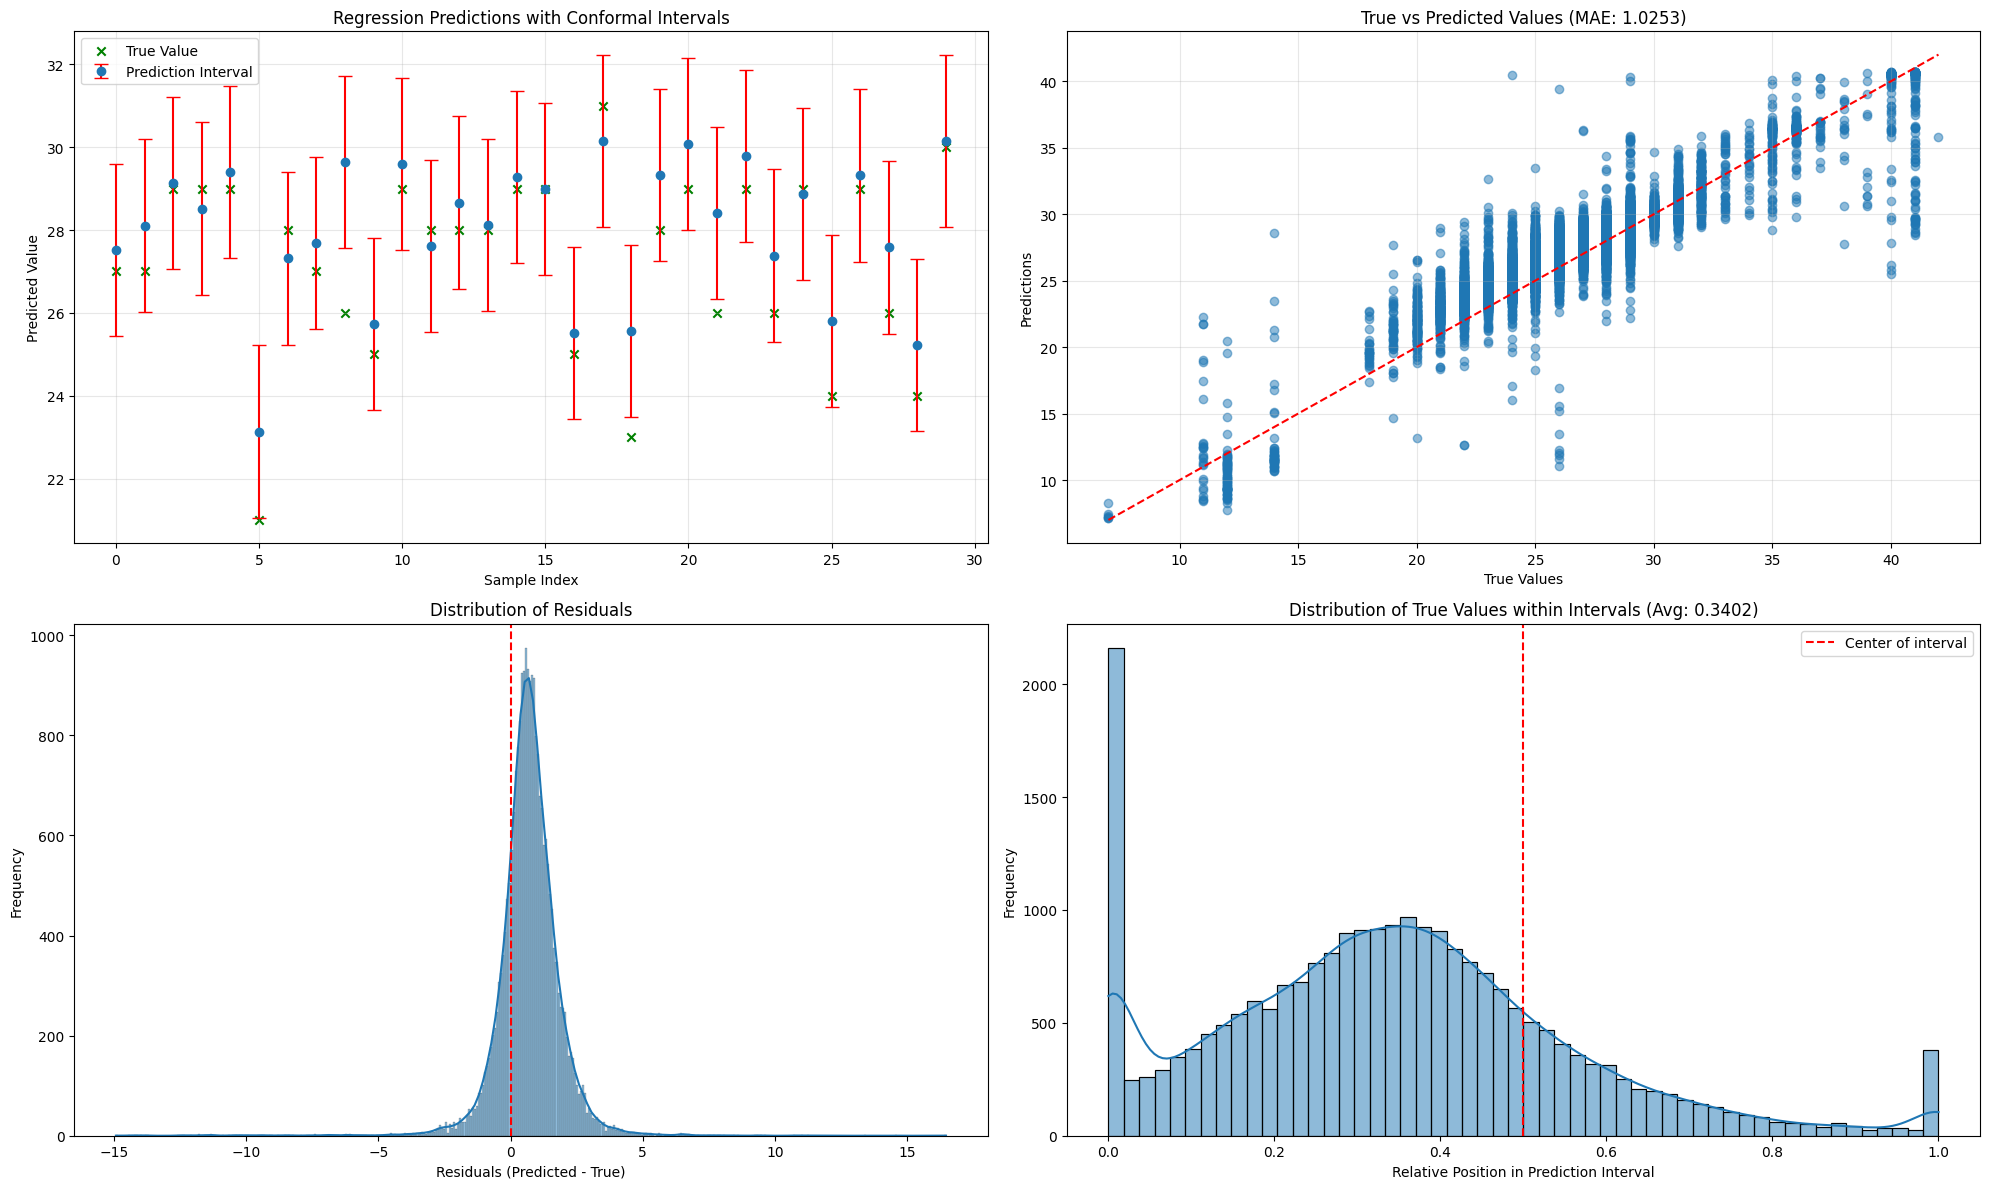


Calibration Check:
Expected coverage: 0.9000, Achieved: 0.9056, Difference: 0.0056


In [641]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'labels' in results:
    # Calculate residuals
    residuals = predictions - labels
    
    # Create a figure with 3 subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 12))
    
    # Plot 1: Prediction intervals for first 30 samples
    n_samples = min(30, len(predictions))
    indices = range(n_samples)
    
    axs[0, 0].errorbar(indices, predictions[:n_samples], 
                    yerr=[predictions[:n_samples] - lower_bounds[:n_samples], 
                          upper_bounds[:n_samples] - predictions[:n_samples]],
                    fmt='o', capsize=5, ecolor='red', label='Prediction Interval')
    axs[0, 0].scatter(indices, labels[:n_samples], color='green', marker='x', label='True Value')
    axs[0, 0].set_xlabel('Sample Index')
    axs[0, 0].set_ylabel('Predicted Value')
    axs[0, 0].set_title('Regression Predictions with Conformal Intervals')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Scatter plot of predicted vs true values
    axs[0, 1].scatter(labels, predictions, alpha=0.5)
    # Add perfect prediction line
    min_val = min(np.min(labels), np.min(predictions))
    max_val = max(np.max(labels), np.max(predictions))
    axs[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--')
    axs[0, 1].set_xlabel('True Values')
    axs[0, 1].set_ylabel('Predictions')
    axs[0, 1].set_title(f'True vs Predicted Values (MAE: {results["mae"]:.4f})')
    axs[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Distribution of residuals
    sns.histplot(residuals, kde=True, ax=axs[1, 0])
    axs[1, 0].axvline(x=0, color='r', linestyle='--')
    axs[1, 0].set_xlabel('Residuals (Predicted - True)')
    axs[1, 0].set_ylabel('Frequency')
    axs[1, 0].set_title('Distribution of Residuals')
    
    # Plot 4: Distribution of rank positions within intervals
    normalized_positions = (labels - lower_bounds) / results['interval_width']
    normalized_positions = np.clip(normalized_positions, 0, 1)
    sns.histplot(normalized_positions, kde=True, ax=axs[1, 1])
    axs[1, 1].axvline(x=0.5, color='r', linestyle='--', label='Center of interval')
    axs[1, 1].set_xlabel('Relative Position in Prediction Interval')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].set_title(f'Distribution of True Values within Intervals (Avg: {results["avg_rank_position"]:.4f})')
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

    # Additional evaluation: Check calibration by plotting empirical coverage vs expected coverage
    # This would typically be done with multiple alpha values, but we'll just print our current result
    print("\nCalibration Check:")
    print(f"Expected coverage: {confidence_level:.4f}, Achieved: {results['coverage']:.4f}, " 
          f"Difference: {results['coverage']-confidence_level:.4f}")

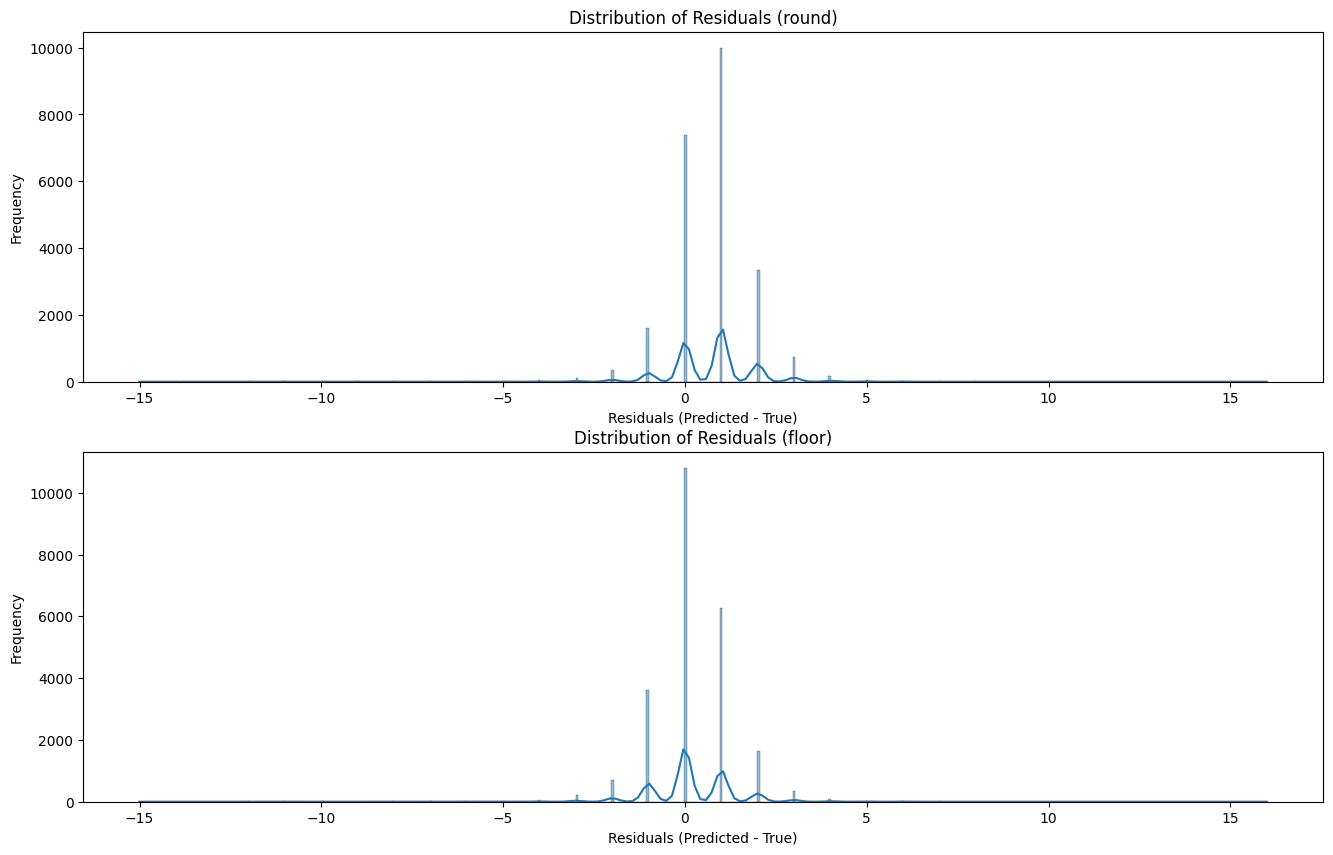

In [659]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'labels' in results:
    # Calculate residuals
    residuals_r = np.round(predictions) - labels
    residuals_f = np.floor(predictions) - labels
    
    # Create a figure with 3 subplots
    fig, axs = plt.subplots(2, 1, figsize=(16, 10))
    
    sns.histplot(residuals_r, kde=True, ax=axs[0])
    #axs[0].axvline(x=0, color='r', linestyle='--')
    axs[0].set_xlabel('Residuals (Predicted - True)')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Distribution of Residuals (round)')
    
    sns.histplot(residuals_f, kde=True, ax=axs[1])
    #axs[1].axvline(x=0, color='r', linestyle='--')
    axs[1].set_xlabel('Residuals (Predicted - True)')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Distribution of Residuals (floor)')
    


Expected coverage: 0.90
Empirical coverage: 0.90
Average interval width: 4.4500


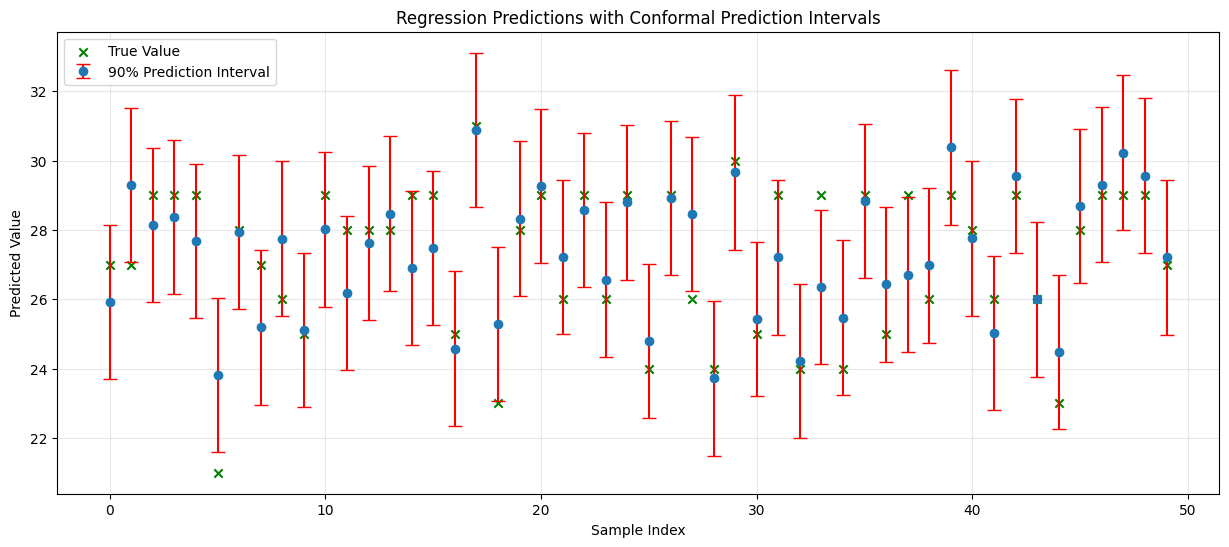

In [574]:
if 'labels' in results:
    labels = results['labels']
    
    # Calculate coverage (proportion of true labels within the prediction intervals)
    coverage = np.mean((labels >= lower_bounds) & (labels <= upper_bounds))
    
    # Calculate average interval width
    avg_width = np.mean(upper_bounds - lower_bounds)
    
    print(f"Expected coverage: {confidence_level:.2f}")
    print(f"Empirical coverage: {coverage:.2f}")
    print(f"Average interval width: {avg_width:.4f}")
    
    # Plot some examples
    import matplotlib.pyplot as plt
    
    # Plot the first 50 predictions with intervals
    plt.figure(figsize=(15, 6))
    indices = range(min(50, len(predictions)))
    plt.errorbar(indices, predictions[indices], 
                yerr=[predictions[indices] - lower_bounds[indices], 
                      upper_bounds[indices] - predictions[indices]],
                fmt='o', capsize=5, ecolor='red', label='90% Prediction Interval')
    plt.scatter(indices, labels[indices], color='green', marker='x', label='True Value')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Value')
    plt.title('Regression Predictions with Conformal Prediction Intervals')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Expected coverage: 0.90
Empirical coverage: 0.91
Average interval width: 4.1556


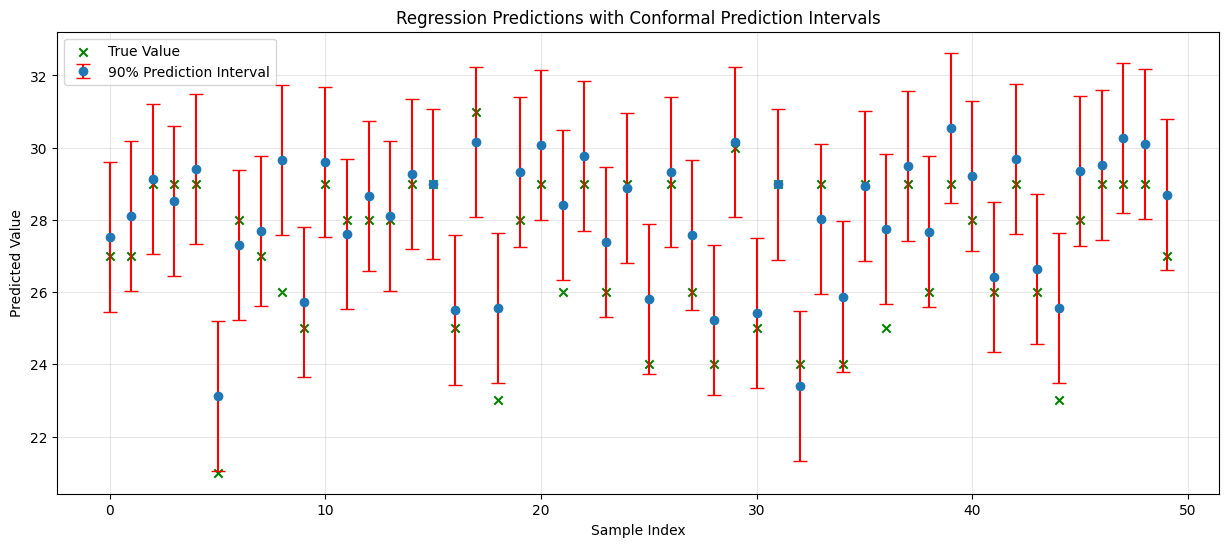

In [660]:
if 'labels' in results:
    labels = results['labels']
    
    # Calculate coverage (proportion of true labels within the prediction intervals)
    coverage = np.mean((labels >= lower_bounds) & (labels <= upper_bounds))
    
    # Calculate average interval width
    avg_width = np.mean(upper_bounds - lower_bounds)
    
    print(f"Expected coverage: {confidence_level:.2f}")
    print(f"Empirical coverage: {coverage:.2f}")
    print(f"Average interval width: {avg_width:.4f}")
    
    # Plot some examples
    import matplotlib.pyplot as plt
    
    # Plot the first 50 predictions with intervals
    plt.figure(figsize=(15, 6))
    indices = range(min(50, len(predictions)))
    plt.errorbar(indices, predictions[indices], 
                yerr=[predictions[indices] - lower_bounds[indices], 
                      upper_bounds[indices] - predictions[indices]],
                fmt='o', capsize=5, ecolor='red', label='90% Prediction Interval')
    plt.scatter(indices, labels[indices], color='green', marker='x', label='True Value')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Value')
    plt.title('Regression Predictions with Conformal Prediction Intervals')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [645]:
np.max(predictions - labels)

16.478443145751953